In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

import FiniteDifference as fd
import LiquidCrystalHelper as lch

from scipy.signal import find_peaks
from scipy.signal import find_peaks_cwt

import time
from importlib import reload

In [2]:
import ipywidgets as widgets
from IPython.display import display
from IPython.display import Video
from IPython.display import Image

In [3]:
reload(lch)

<module 'LiquidCrystalHelper' from 'C:\\Users\\lucas\\Documents\\Grad Work\\Summer Research 2020\\LiquidCrystalHelper.py'>

In [4]:
%matplotlib inline
dpi = 700
mpl.rcParams['figure.dpi'] = dpi

In [5]:
l = 10
n = 300

x = np.linspace(-l, l, num=n)
y = np.linspace(-l, l, num=n)
X, Y = np.meshgrid(x, y, indexing='ij')

In [6]:
S_val = 0.5
ctr = [[-2, 0], [2, 0]]
r = [1, 1]
m = [-1/2, 1/2]

S, phi = lch.makeMultiDisclination(X, Y, S_val, ctr, r, m)
Q = lch.uniaxialQ(S, phi)
eta, mu, nu = lch.auxVars(Q)

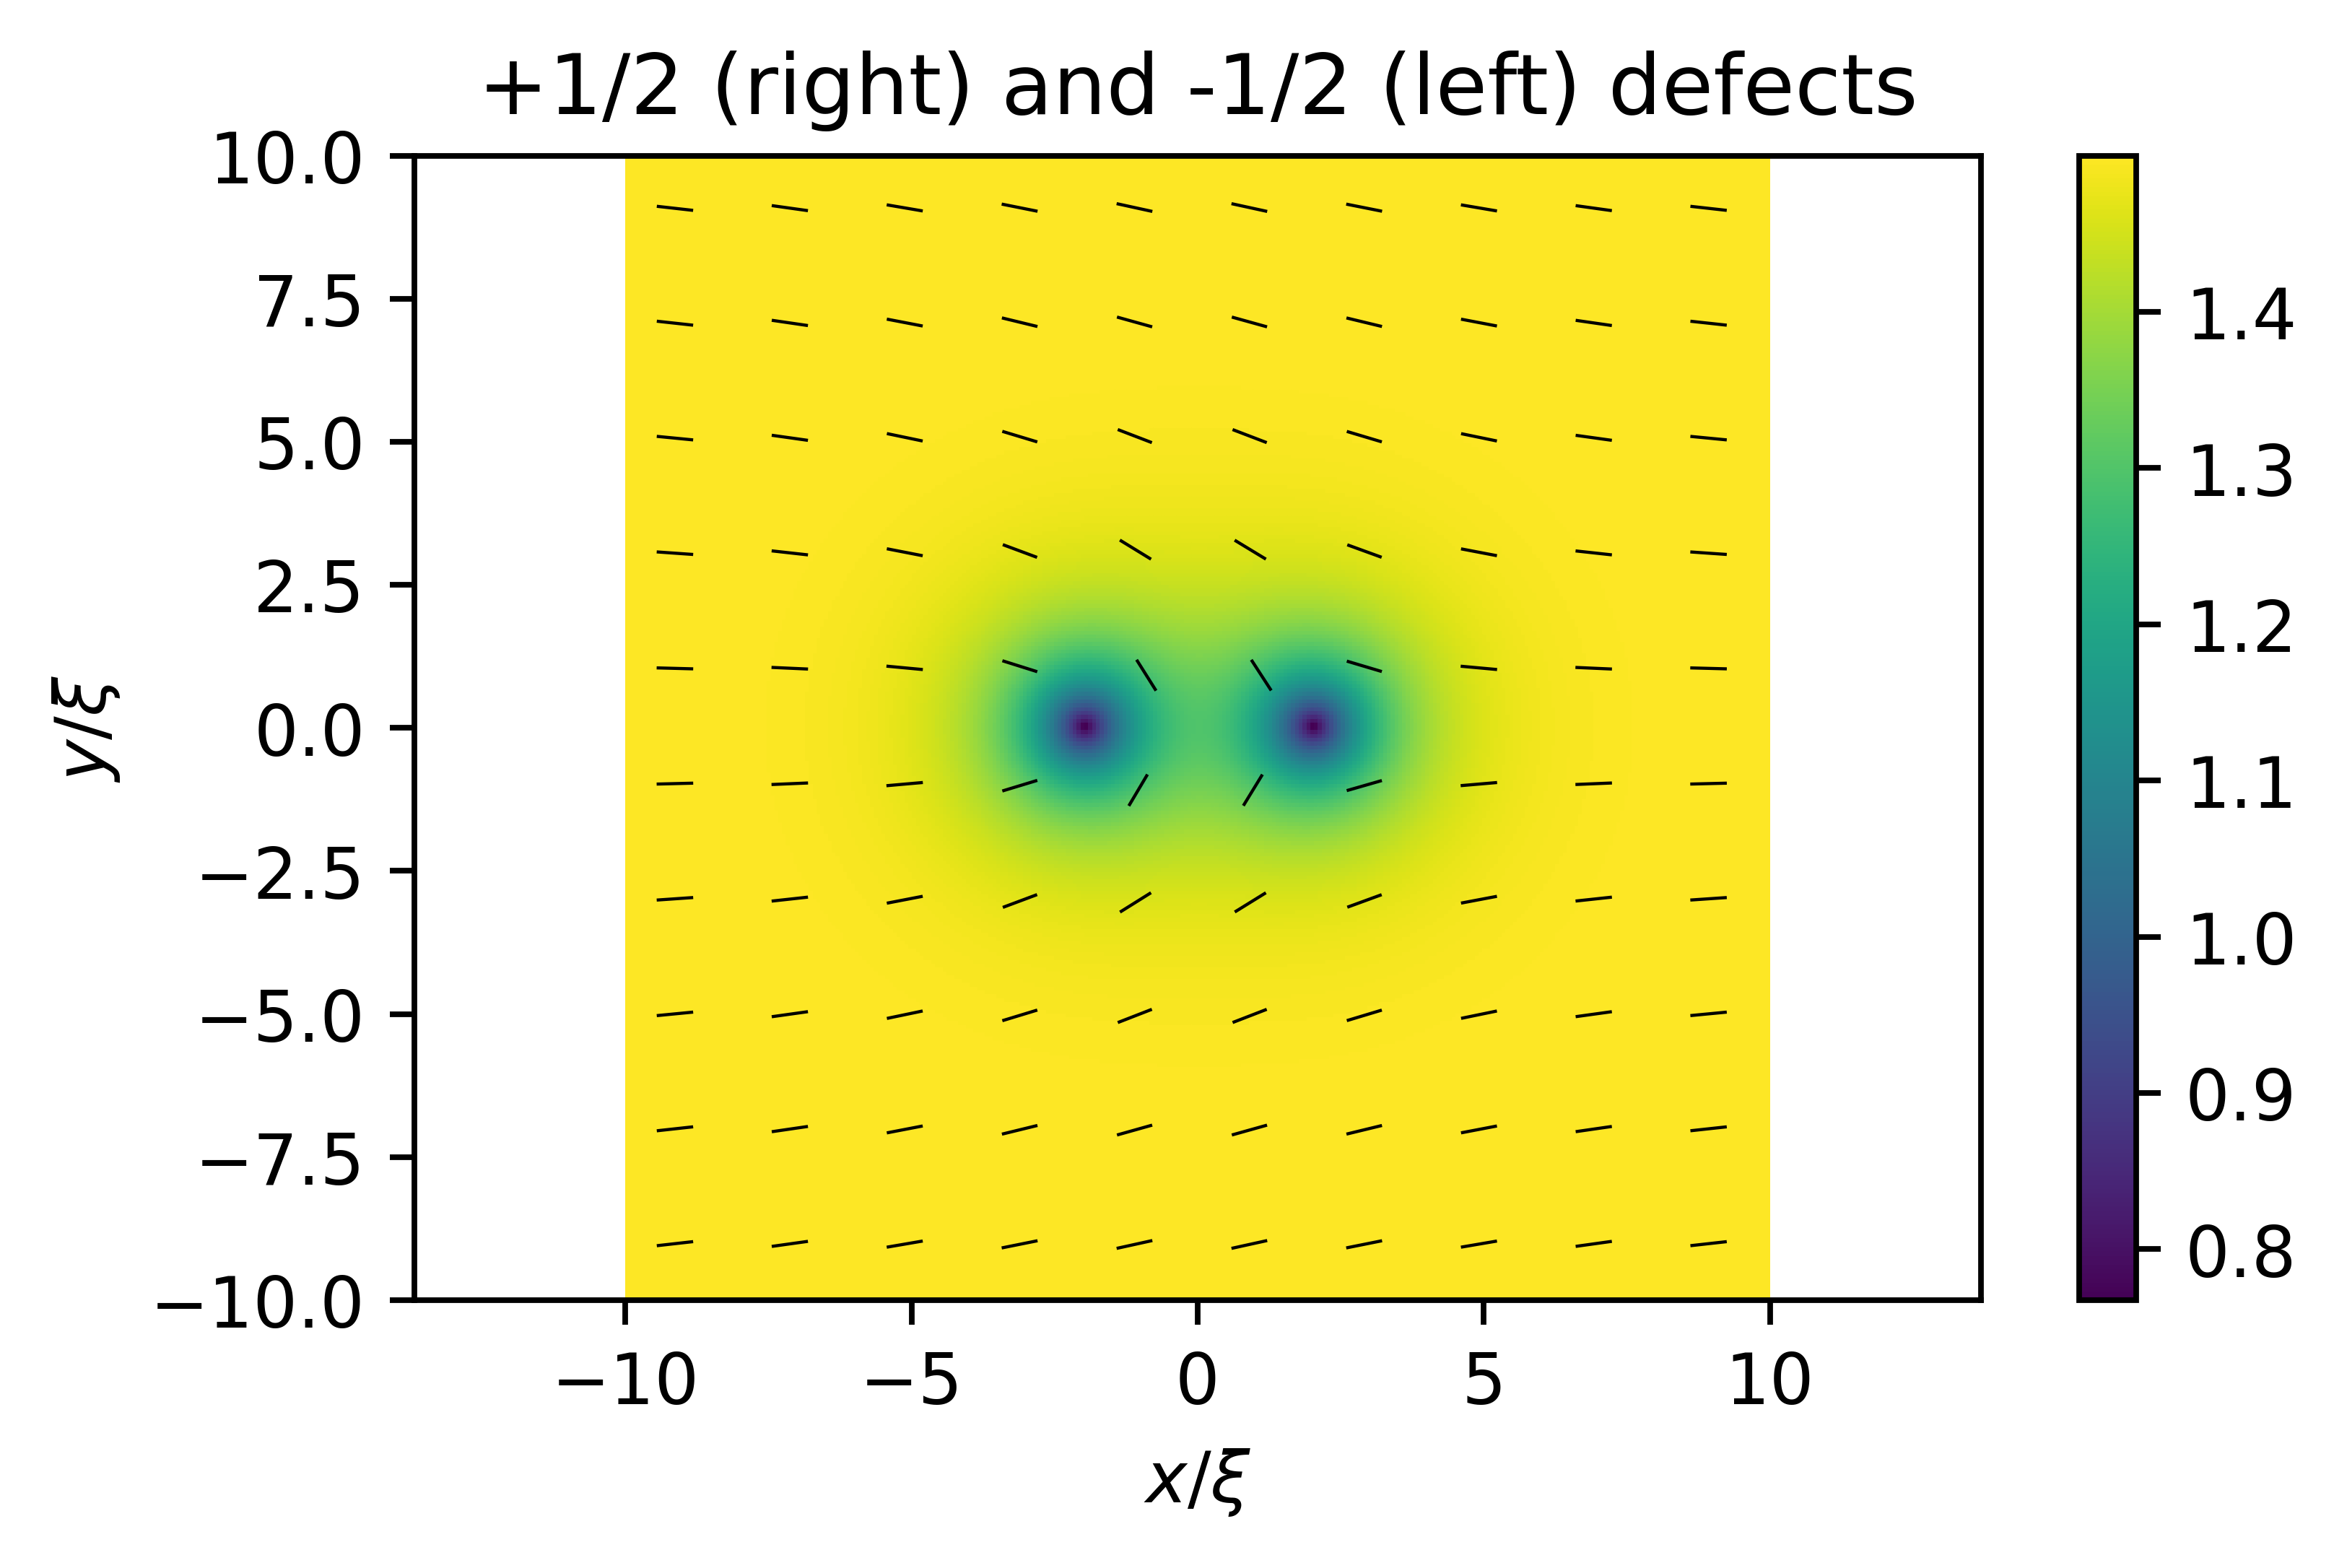

In [11]:
sparse_shape = (10, 10)
S_sparse_shape = (200, 200)
S_cutoff = 0.3

lambda_max = lch.calcQEigenvals(eta, mu, nu)
U, V = lch.calcQEigenvecs(eta, mu, nu, lambda_max, S_cutoff)

sparse_idx = lch.sparseIdx(Q[0, 0].shape, sparse_shape)
S_sparse_idx = lch.sparseIdx(Q[0, 0].shape, S_sparse_shape)

fig, ax = plt.subplots(figsize=(5, 3))
c = ax.pcolor(X[S_sparse_idx], Y[S_sparse_idx], (3/2)*lambda_max[S_sparse_idx])
q = ax.quiver(X[sparse_idx], Y[sparse_idx], U[sparse_idx], V[sparse_idx],
              headwidth=0, pivot='middle', headaxislength=5, scale=30, width=0.002)
# ax.quiverkey(q, X=0.3, Y=1.1, U=10,
#              label='Quiver key, length = 10', labelpos='E')
ax.axis('equal')
fig.colorbar(c, ax=ax)
ax.set_title("+1/2 (right) and -1/2 (left) defects")
ax.set_xlabel(r"$x/\xi$")
ax.set_ylabel(r"$y/\xi$")

fig.savefig("TwoDefects.png")

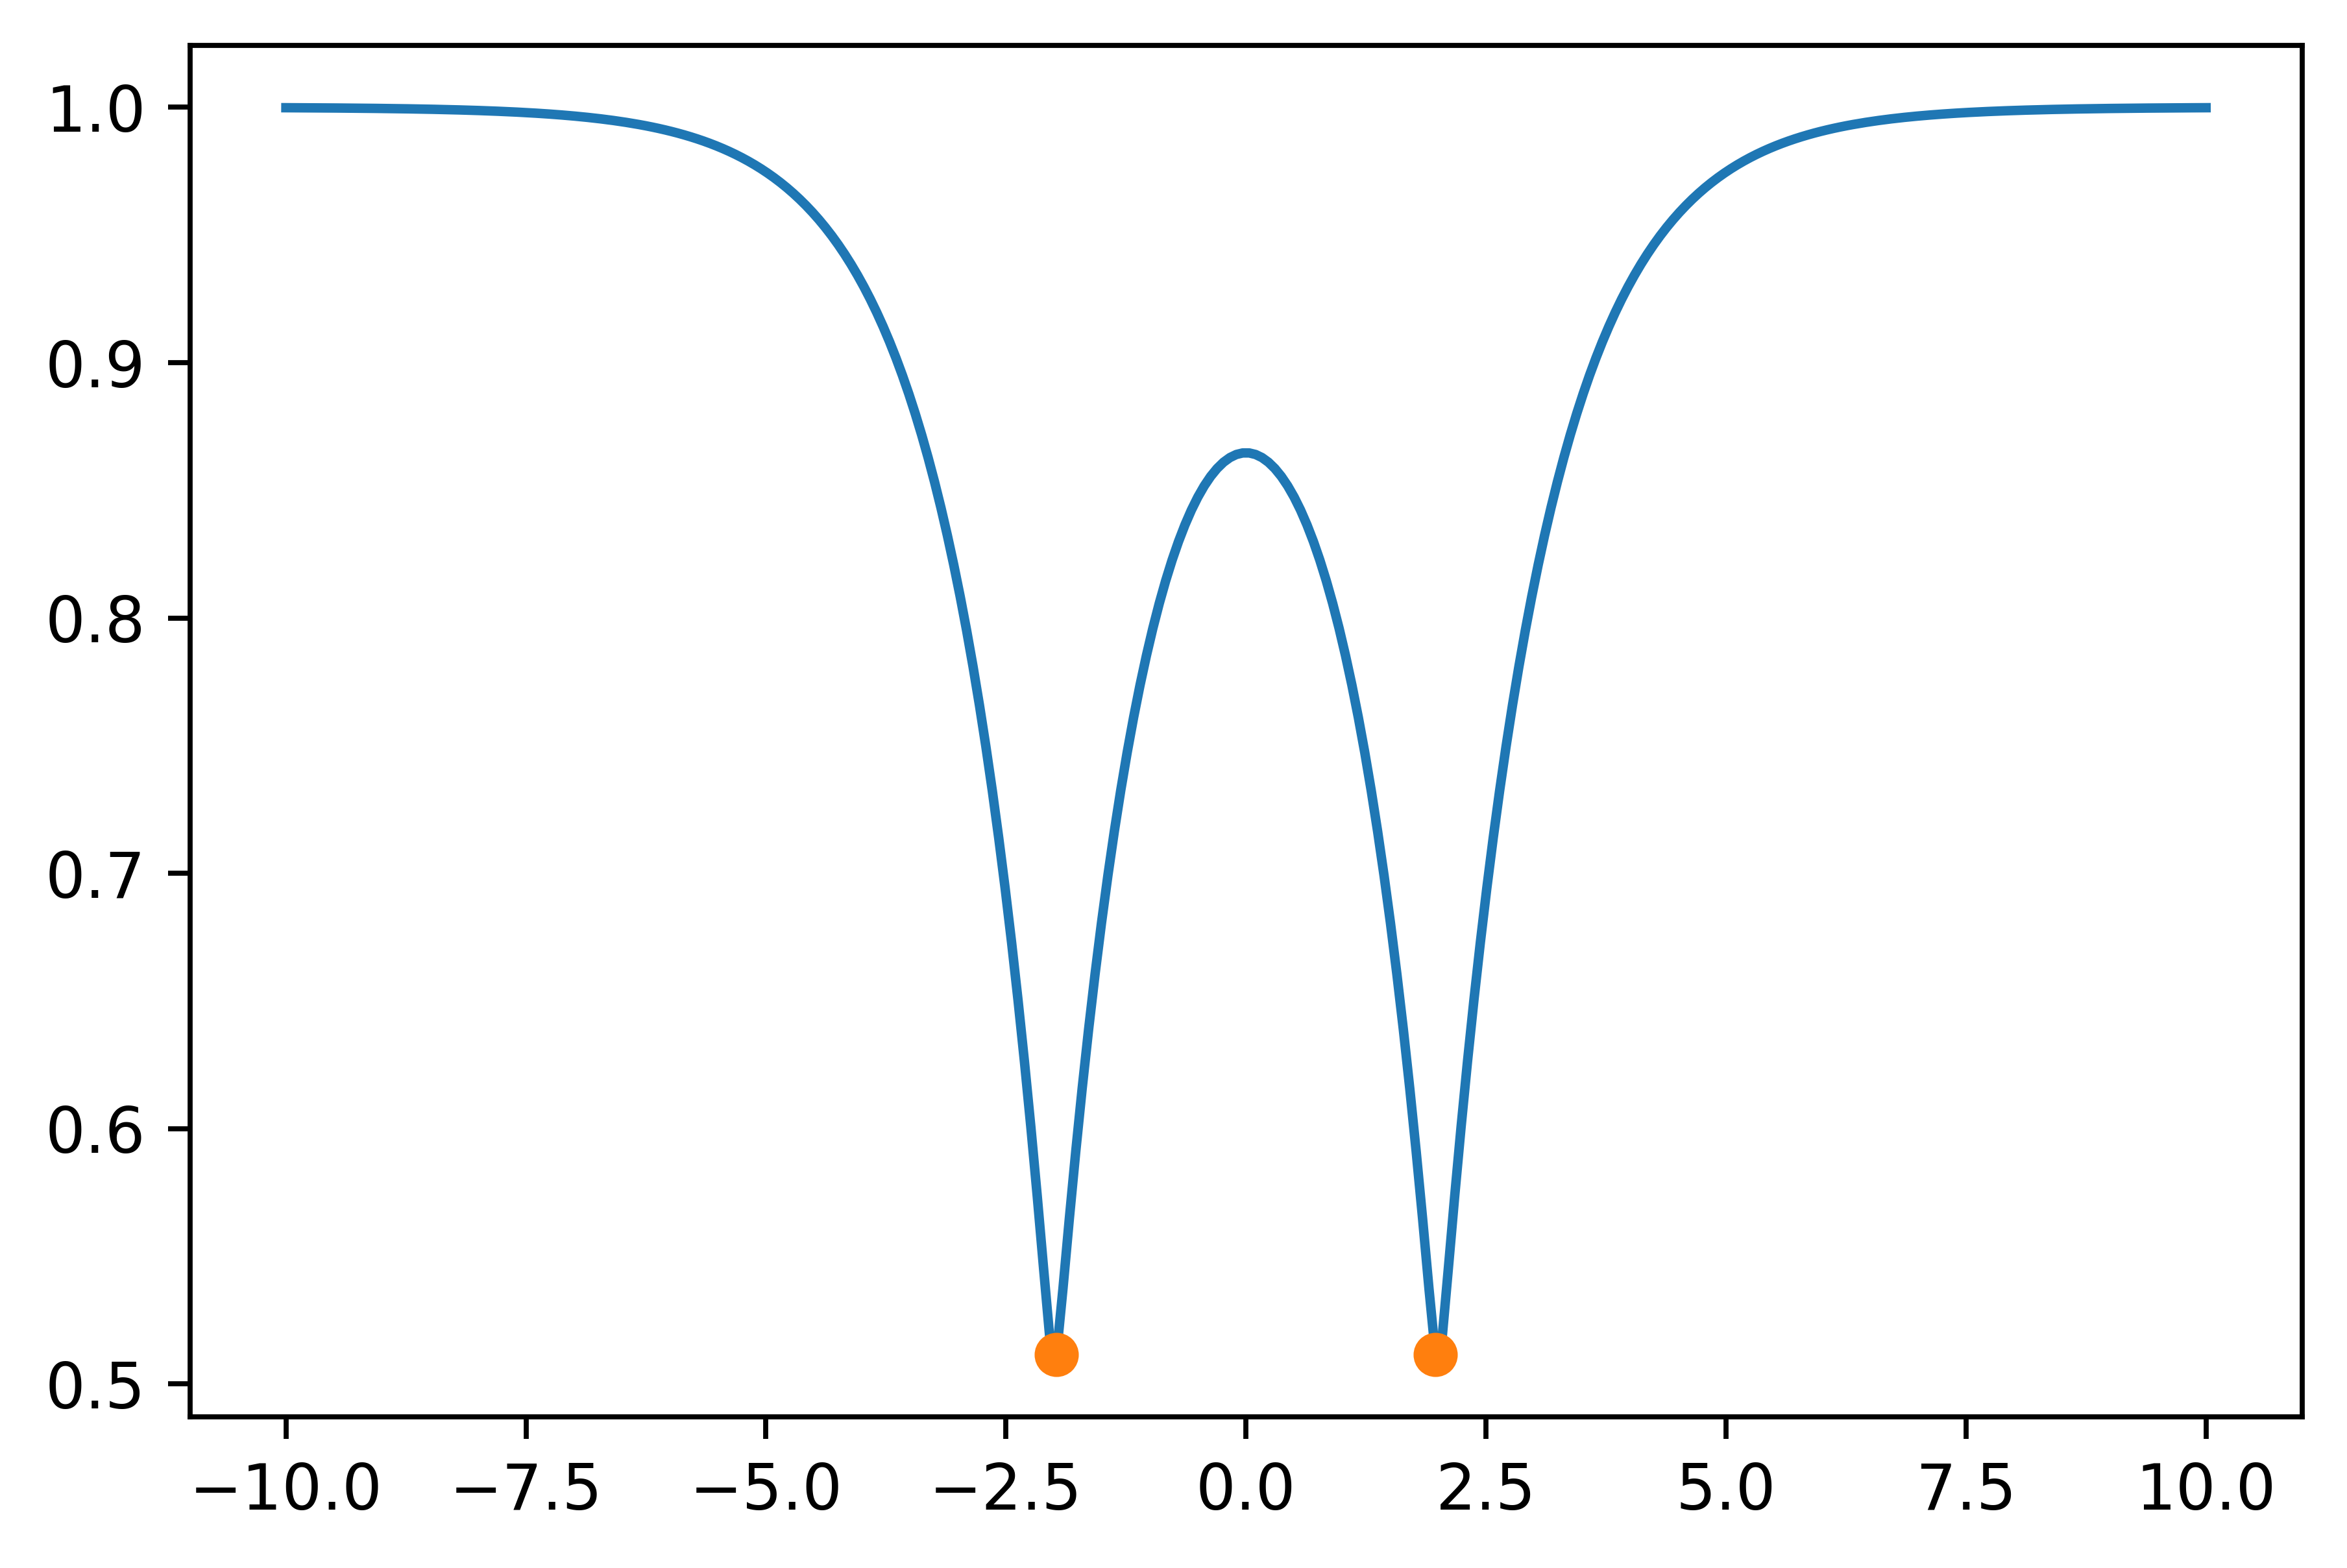

In [12]:
middle = np.floor(n/2).astype('int')
peaks, _ = find_peaks(-lambda_max[:, middle])

plt.plot(X[:, middle], lambda_max[:, middle])
plt.plot(X[peaks, middle], lambda_max[peaks, middle], marker='o', ls='')

In [13]:
dx = X[1, 0] - X[0, 0]
dy = Y[0, 1] - Y[0, 0]

# This is just what they said it should be for stability
dt = dx**2/8

In [14]:
num_steps = 10000
peak_pos = np.zeros((2, num_steps))
t = np.zeros(num_steps)
widths = np.arange(0, 1.5, 0.05)

middle_slice = np.zeros((n, num_steps))

eta_old = eta
mu_old = mu
nu_old = nu

# Create loading bar
progress = widgets.IntProgress(min=0, max=num_steps)
display(progress)

for i in range(num_steps):
    
    eta_new = fd.forwardEuler(eta_old, dt, lch.etaEOM, mu_old, nu_old, dx, dy)
    mu_new = fd.forwardEuler(mu_old, dt, lch.muEOM, eta_old, nu_old, dx, dy)
    nu_new = fd.forwardEuler(nu_old, dt, lch.nuEOM, eta_old, mu_old, dx, dy)
    
    eta_old = eta_new
    mu_old = mu_new
    nu_old = nu_new
    
    lambda_max = lch.calcQEigenvals(eta_old, mu_old, nu_old)
    peaks, _ = find_peaks(-lambda_max[:, middle])
    peak_pos[:, i] = X[peaks, middle]
    
    middle_slice[:, i] = lambda_max[:, middle]
    
    t[i] = i*dt
    
    # Update loading bar
    progress.value = i


IntProgress(value=0, max=10000)

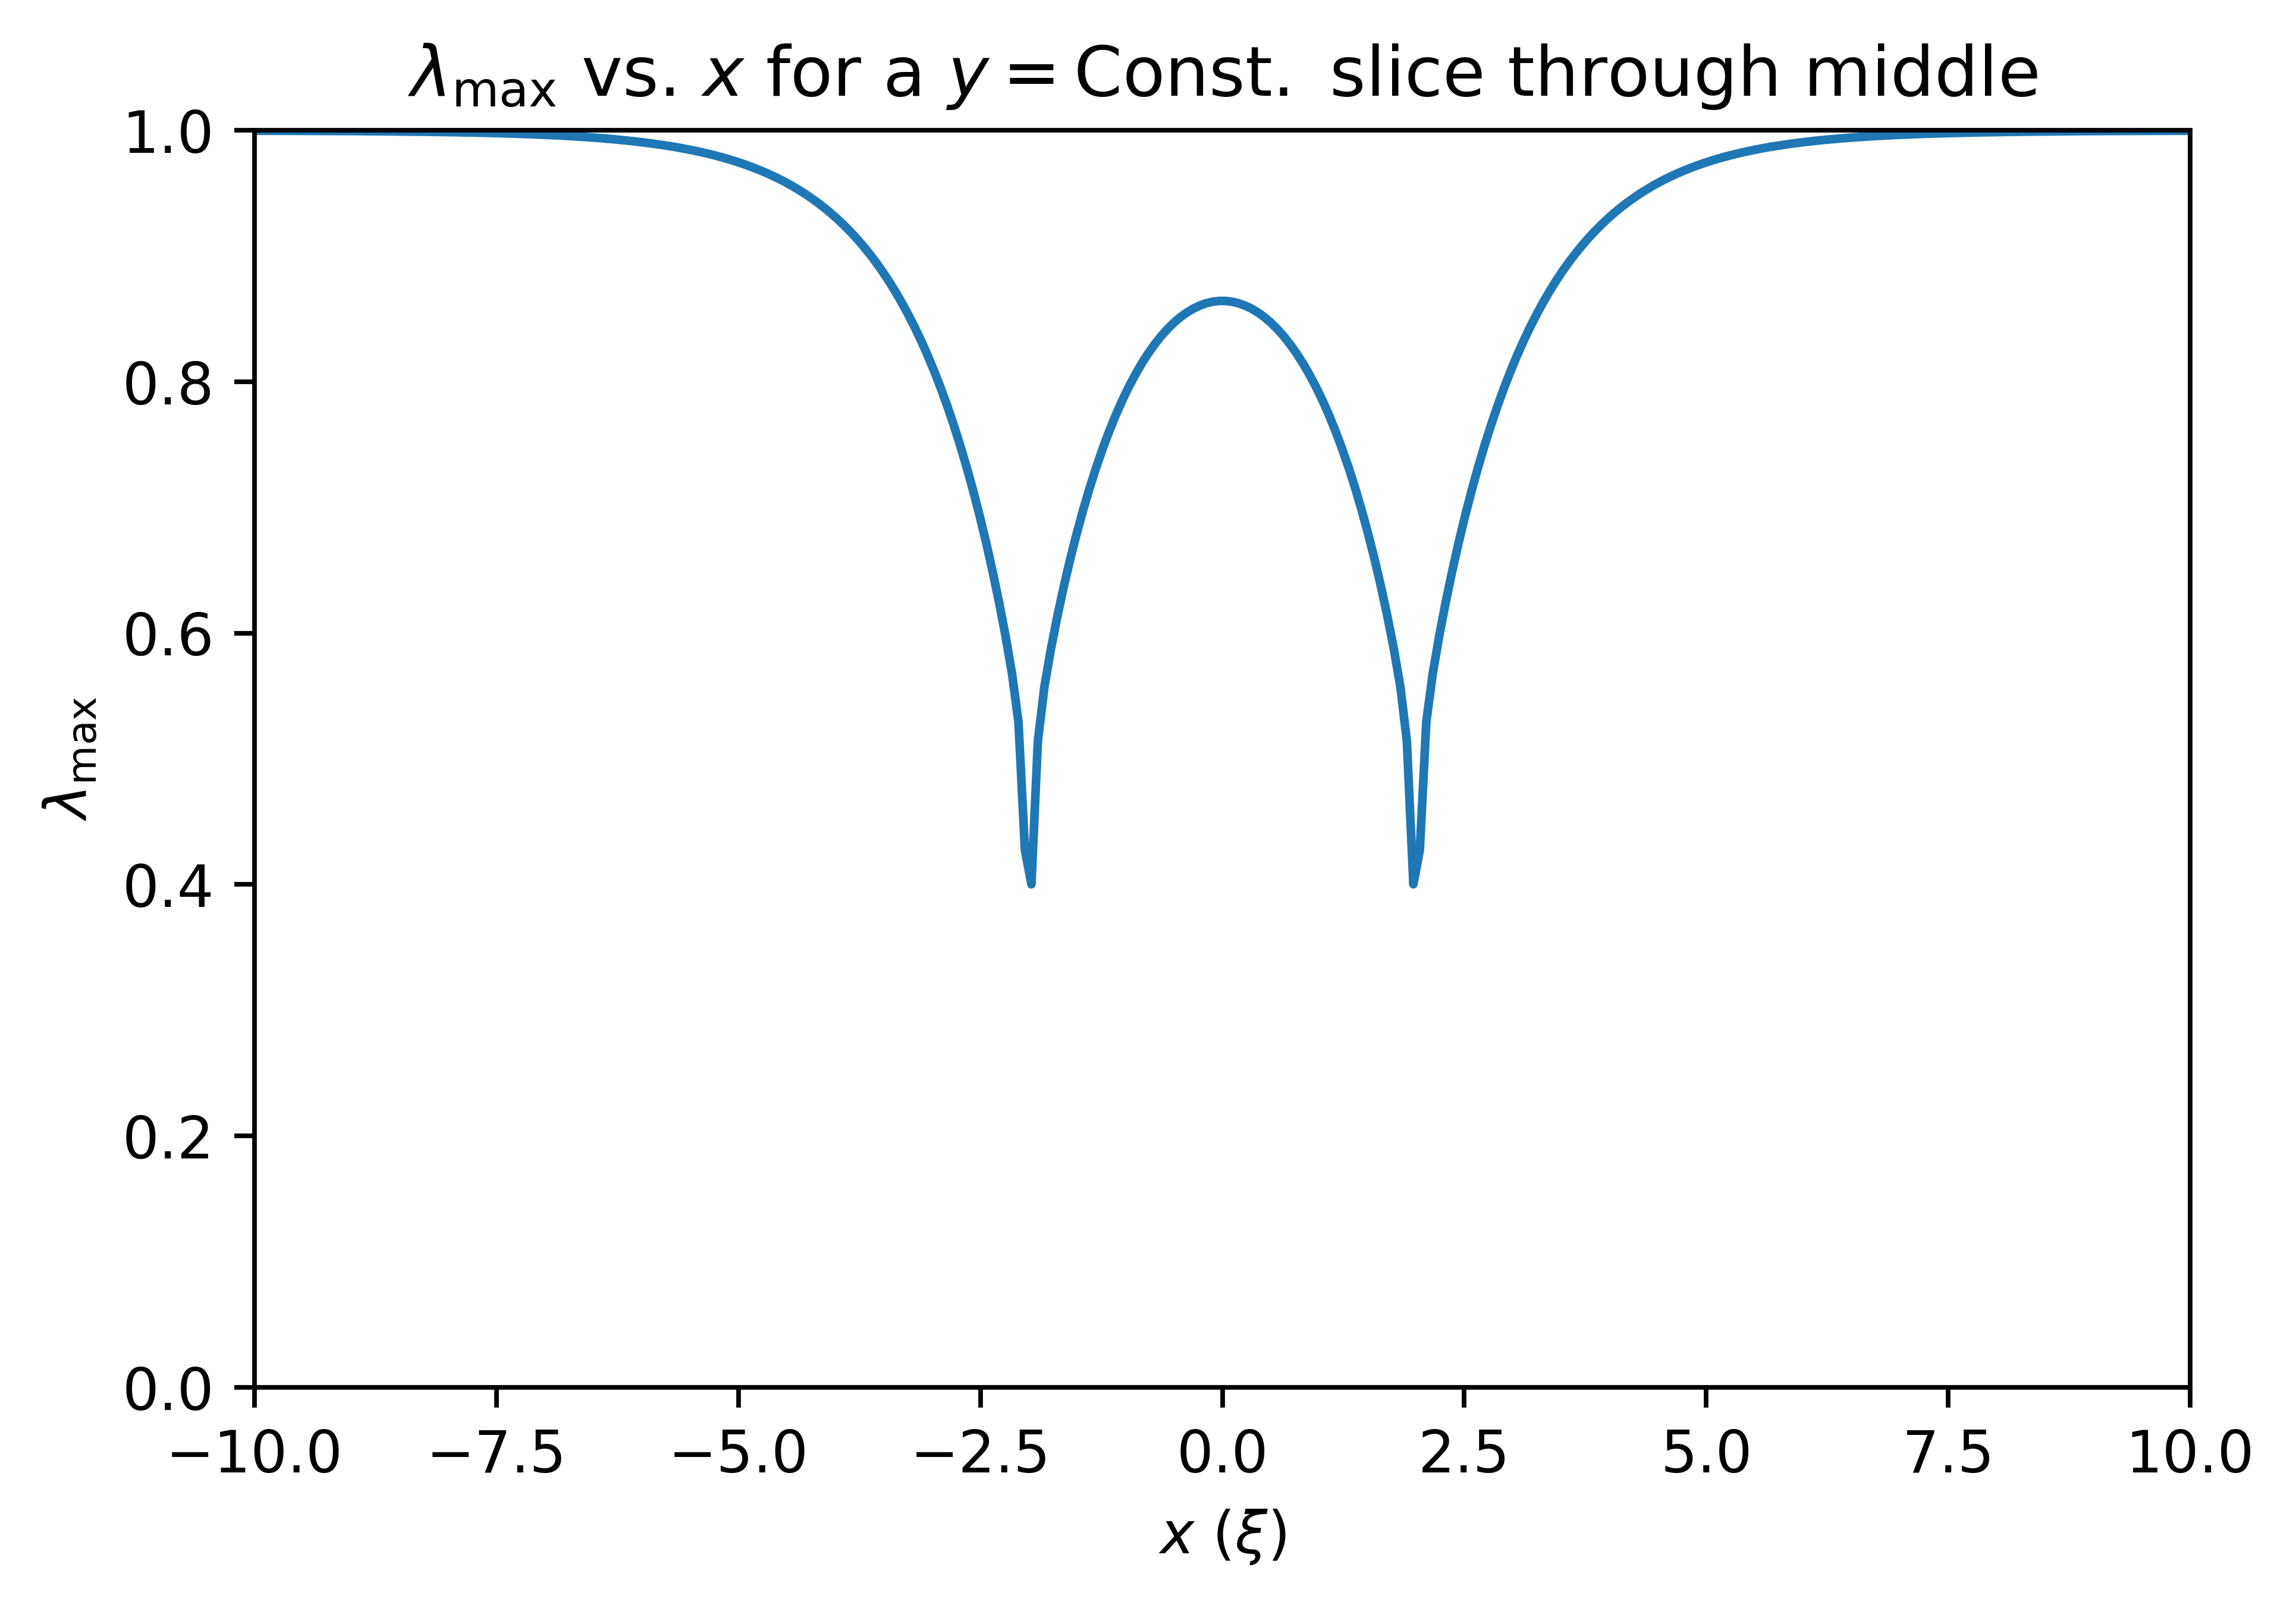

In [15]:
S_val = 1

fig, ax = plt.subplots()
xdata, ydata = X[:, middle], middle_slice[:, 0]
ln, = plt.plot(xdata, ydata)
plt.title(r"$\lambda_\mathrm{max}$ vs. $x$ for a $y = \mathrm{Const.}$ slice through middle")
plt.xlabel(r"$x$ ($\xi$)")
plt.ylabel(r"$\lambda_\mathrm{max}$")

def init(l=l, S_val=S_val):
    ax.set_xlim(-l, l)
    ax.set_ylim(0, S_val)
    return ln,

def update(frame, X=X, middle_slice=middle_slice, middle=middle):
    xdata = X[:, middle]
    ydata = middle_slice[:, frame]
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.arange(0, 5000),
                    init_func=init, interval=2, blit=True)
plt.show()

In [16]:
ani.save("MiddleSliceTimeEvolution300Pts.mp4", dpi=200)

# Results from animating and plotting

In [17]:
Video("MiddleSliceTimeEvolution300Pts.mp4")

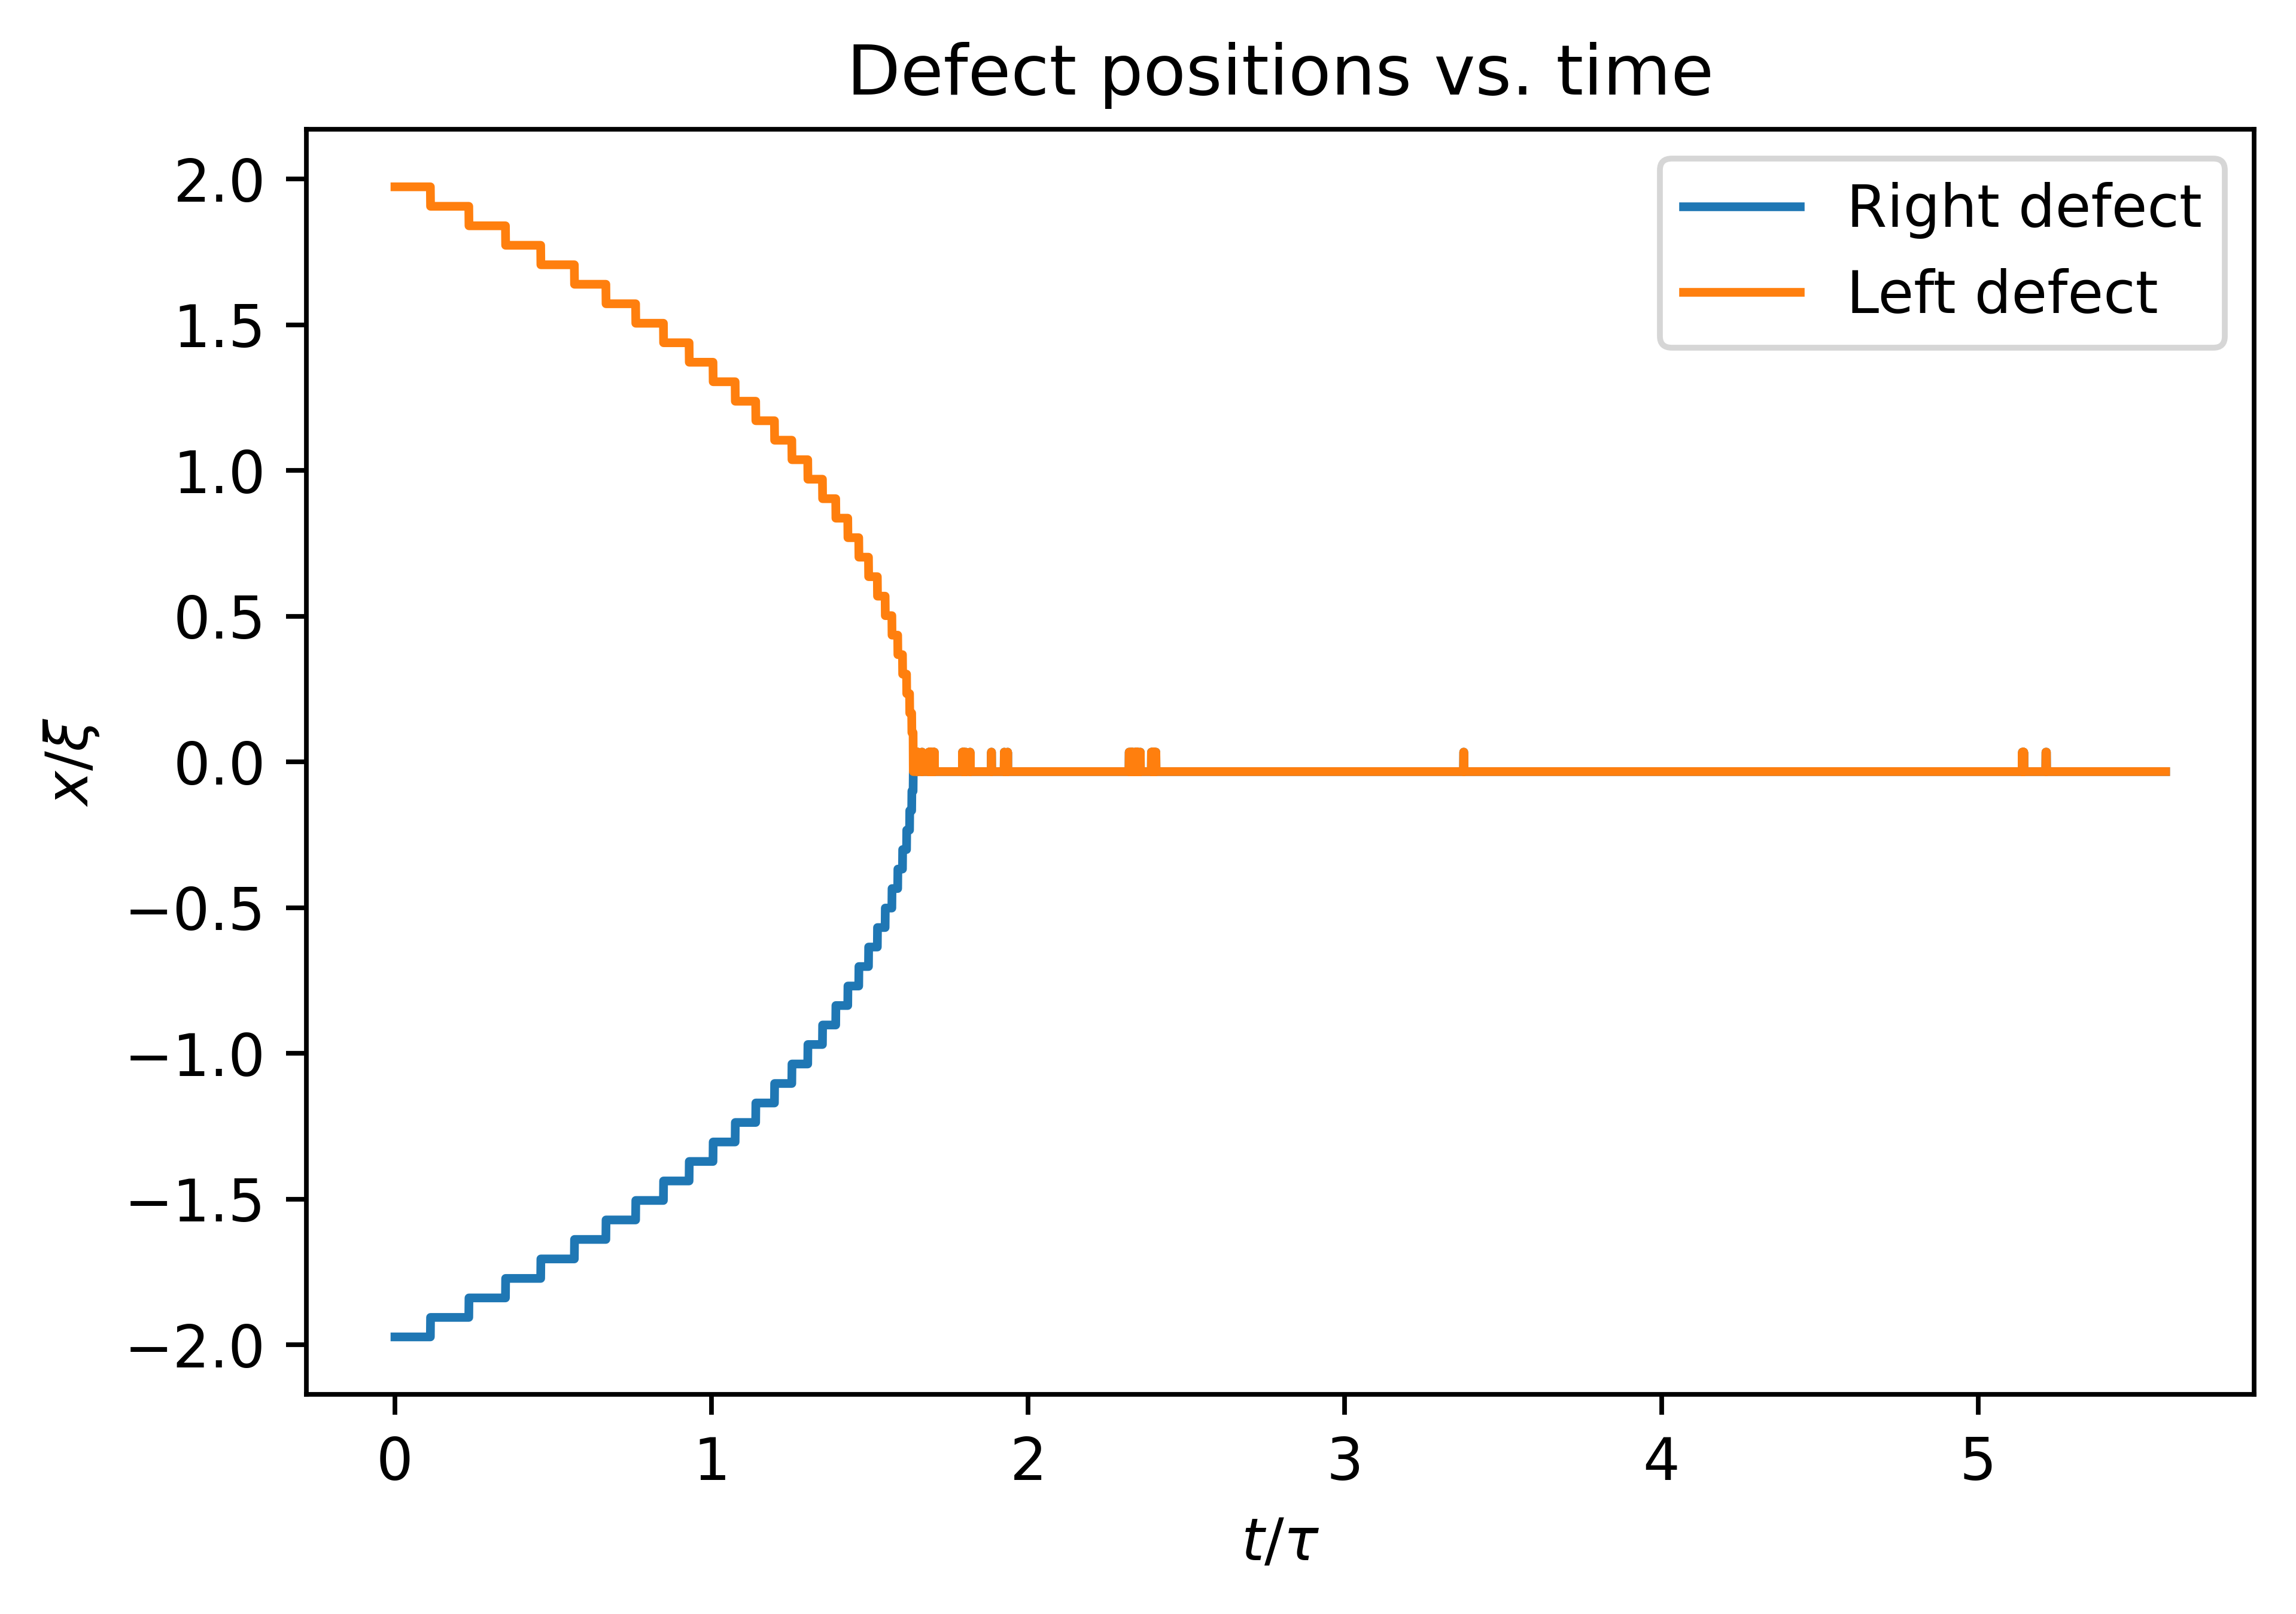

In [21]:
plt.plot(t, peak_pos[0, :], label="+1/2 defect")
plt.plot(t, peak_pos[1, :], label="-1/2 defect")
plt.title("Defect positions vs. time")
plt.xlabel(r"$t/\tau$")
plt.ylabel(r"$x/\xi$")
plt.legend()

plt.savefig("DefectPosVsTime300pts.png")

-------

### Let's try the simulation with 600 points now to see if it gets smoothed out

In [22]:
l = 10
n = 600

x = np.linspace(-l, l, num=n)
y = np.linspace(-l, l, num=n)
X, Y = np.meshgrid(x, y, indexing='ij')

S_val = 0.5
ctr = [[-2, 0], [2, 0]]
r = [1, 1]
m = [-1/2, 1/2]

S, phi = lch.makeMultiDisclination(X, Y, S_val, ctr, r, m)
Q = lch.uniaxialQ(S, phi)
eta, mu, nu = lch.auxVars(Q)

Text(0, 0.5, '$y/\\xi$')

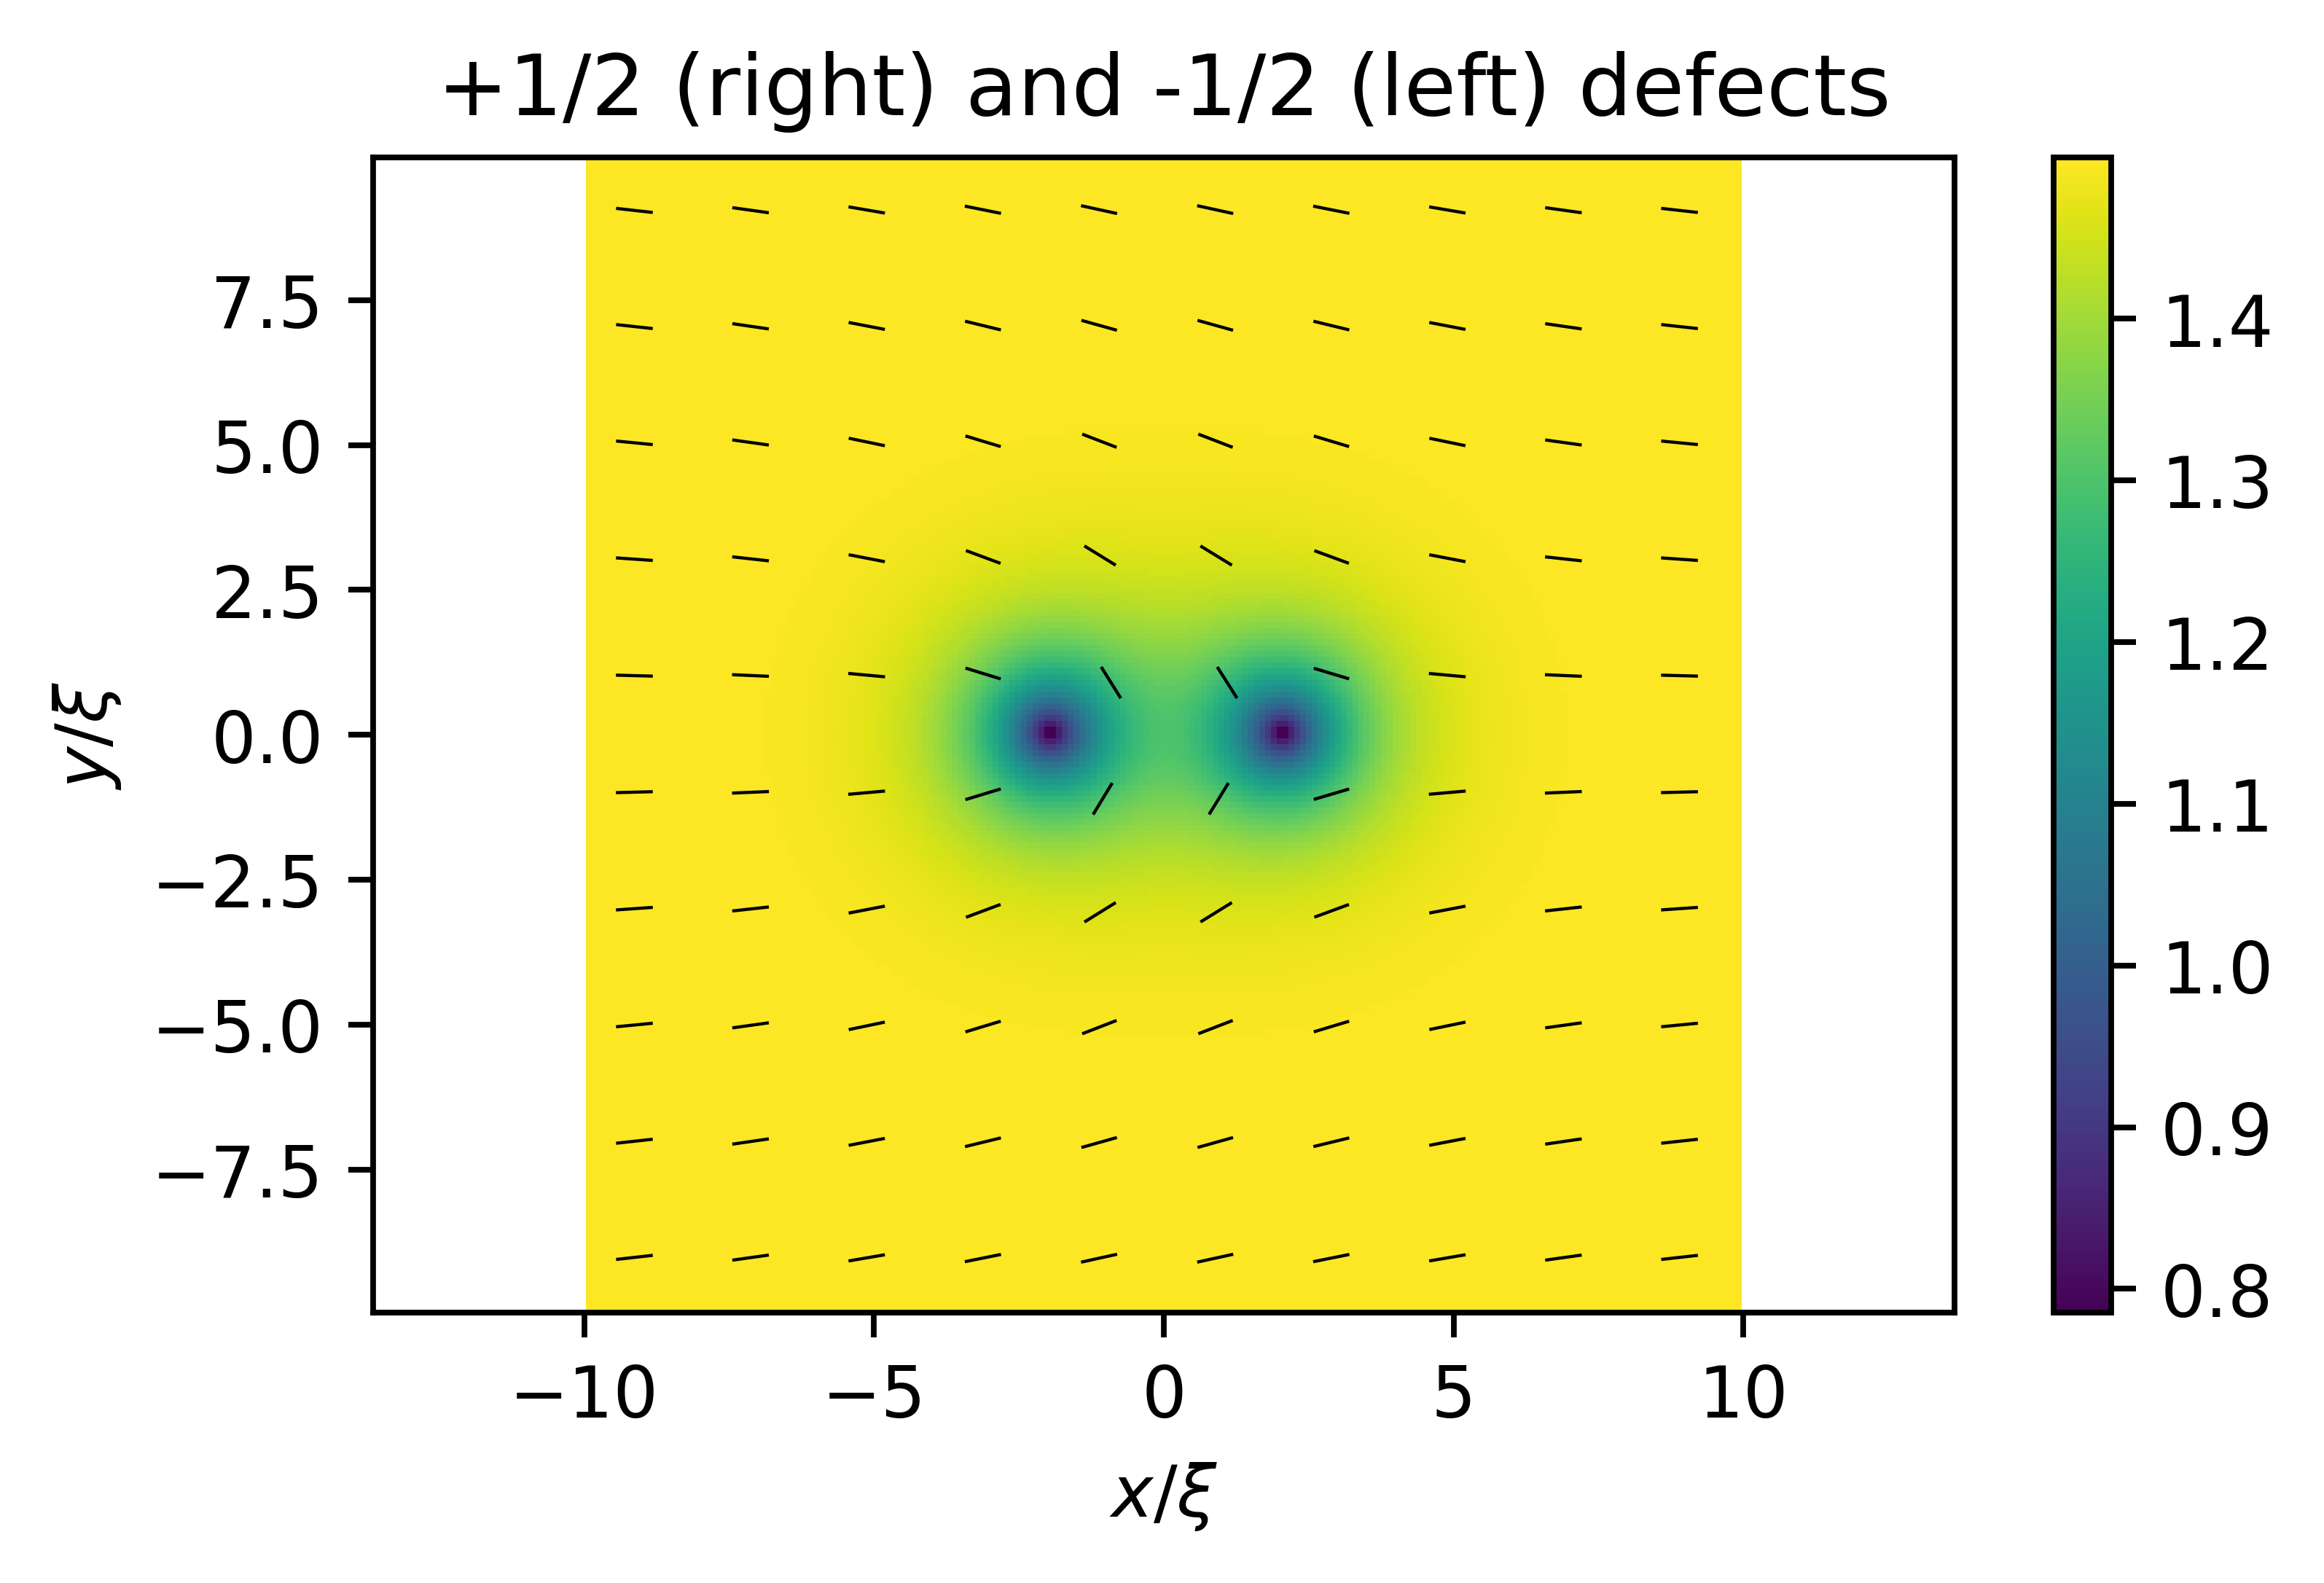

In [25]:
sparse_shape = (10, 10)
S_sparse_shape = (200, 200)
S_cutoff = 0.3

lambda_max = lch.calcQEigenvals(eta, mu, nu)
U, V = lch.calcQEigenvecs(eta, mu, nu, lambda_max, S_cutoff)

sparse_idx = lch.sparseIdx(Q[0, 0].shape, sparse_shape)
S_sparse_idx = lch.sparseIdx(Q[0, 0].shape, S_sparse_shape)

fig, ax = plt.subplots(figsize=(5, 3))
c = ax.pcolor(X[S_sparse_idx], Y[S_sparse_idx], (3/2)*lambda_max[S_sparse_idx])
q = ax.quiver(X[sparse_idx], Y[sparse_idx], U[sparse_idx], V[sparse_idx],
              headwidth=0, pivot='middle', headaxislength=5, scale=30, width=0.002)
# ax.quiverkey(q, X=0.3, Y=1.1, U=10,
#              label='Quiver key, length = 10', labelpos='E')
ax.axis('equal')
fig.colorbar(c, ax=ax)
ax.set_title("+1/2 (left) and -1/2 (right) defects")
ax.set_xlabel(r"$x/\xi$")
ax.set_ylabel(r"$y/\xi$")

In [29]:
dx = X[1, 0] - X[0, 0]
dy = Y[0, 1] - Y[0, 0]

# This is just what they said it should be for stability
dt = dx**2/8

num_steps = 10000
peak_pos = np.zeros((2, num_steps))
t = np.zeros(num_steps)
widths = np.arange(0, 1.5, 0.05)

middle = np.floor(n/2).astype('int')
middle_slice = np.zeros((n, num_steps))

eta_old = eta
mu_old = mu
nu_old = nu

# Create loading bar
progress = widgets.IntProgress(min=0, max=num_steps)
display(progress)

start_time = time.perf_counter()
for i in range(num_steps):
    
    eta_new = fd.forwardEuler(eta_old, dt, lch.etaEOM, mu_old, nu_old, dx, dy)
    mu_new = fd.forwardEuler(mu_old, dt, lch.muEOM, eta_old, nu_old, dx, dy)
    nu_new = fd.forwardEuler(nu_old, dt, lch.nuEOM, eta_old, mu_old, dx, dy)
    
    eta_old = eta_new
    mu_old = mu_new
    nu_old = nu_new
    
    lambda_max = lch.calcQEigenvals(eta_old, mu_old, nu_old)
    peaks, _ = find_peaks(-lambda_max[:, middle])
    peak_pos[:, i] = X[peaks, middle]
    
    middle_slice[:, i] = lambda_max[:, middle]
    
    t[i] = i*dt
    
    # Update loading bar
    progress.value = i
    
end_time = time.perf_counter()
print("Total time elapsed is", end_time - start_time)

IntProgress(value=0, max=10000)

Total time elapsed is 2733.297306399996


In [30]:
(end_time - start_time)/60

45.554955106666604

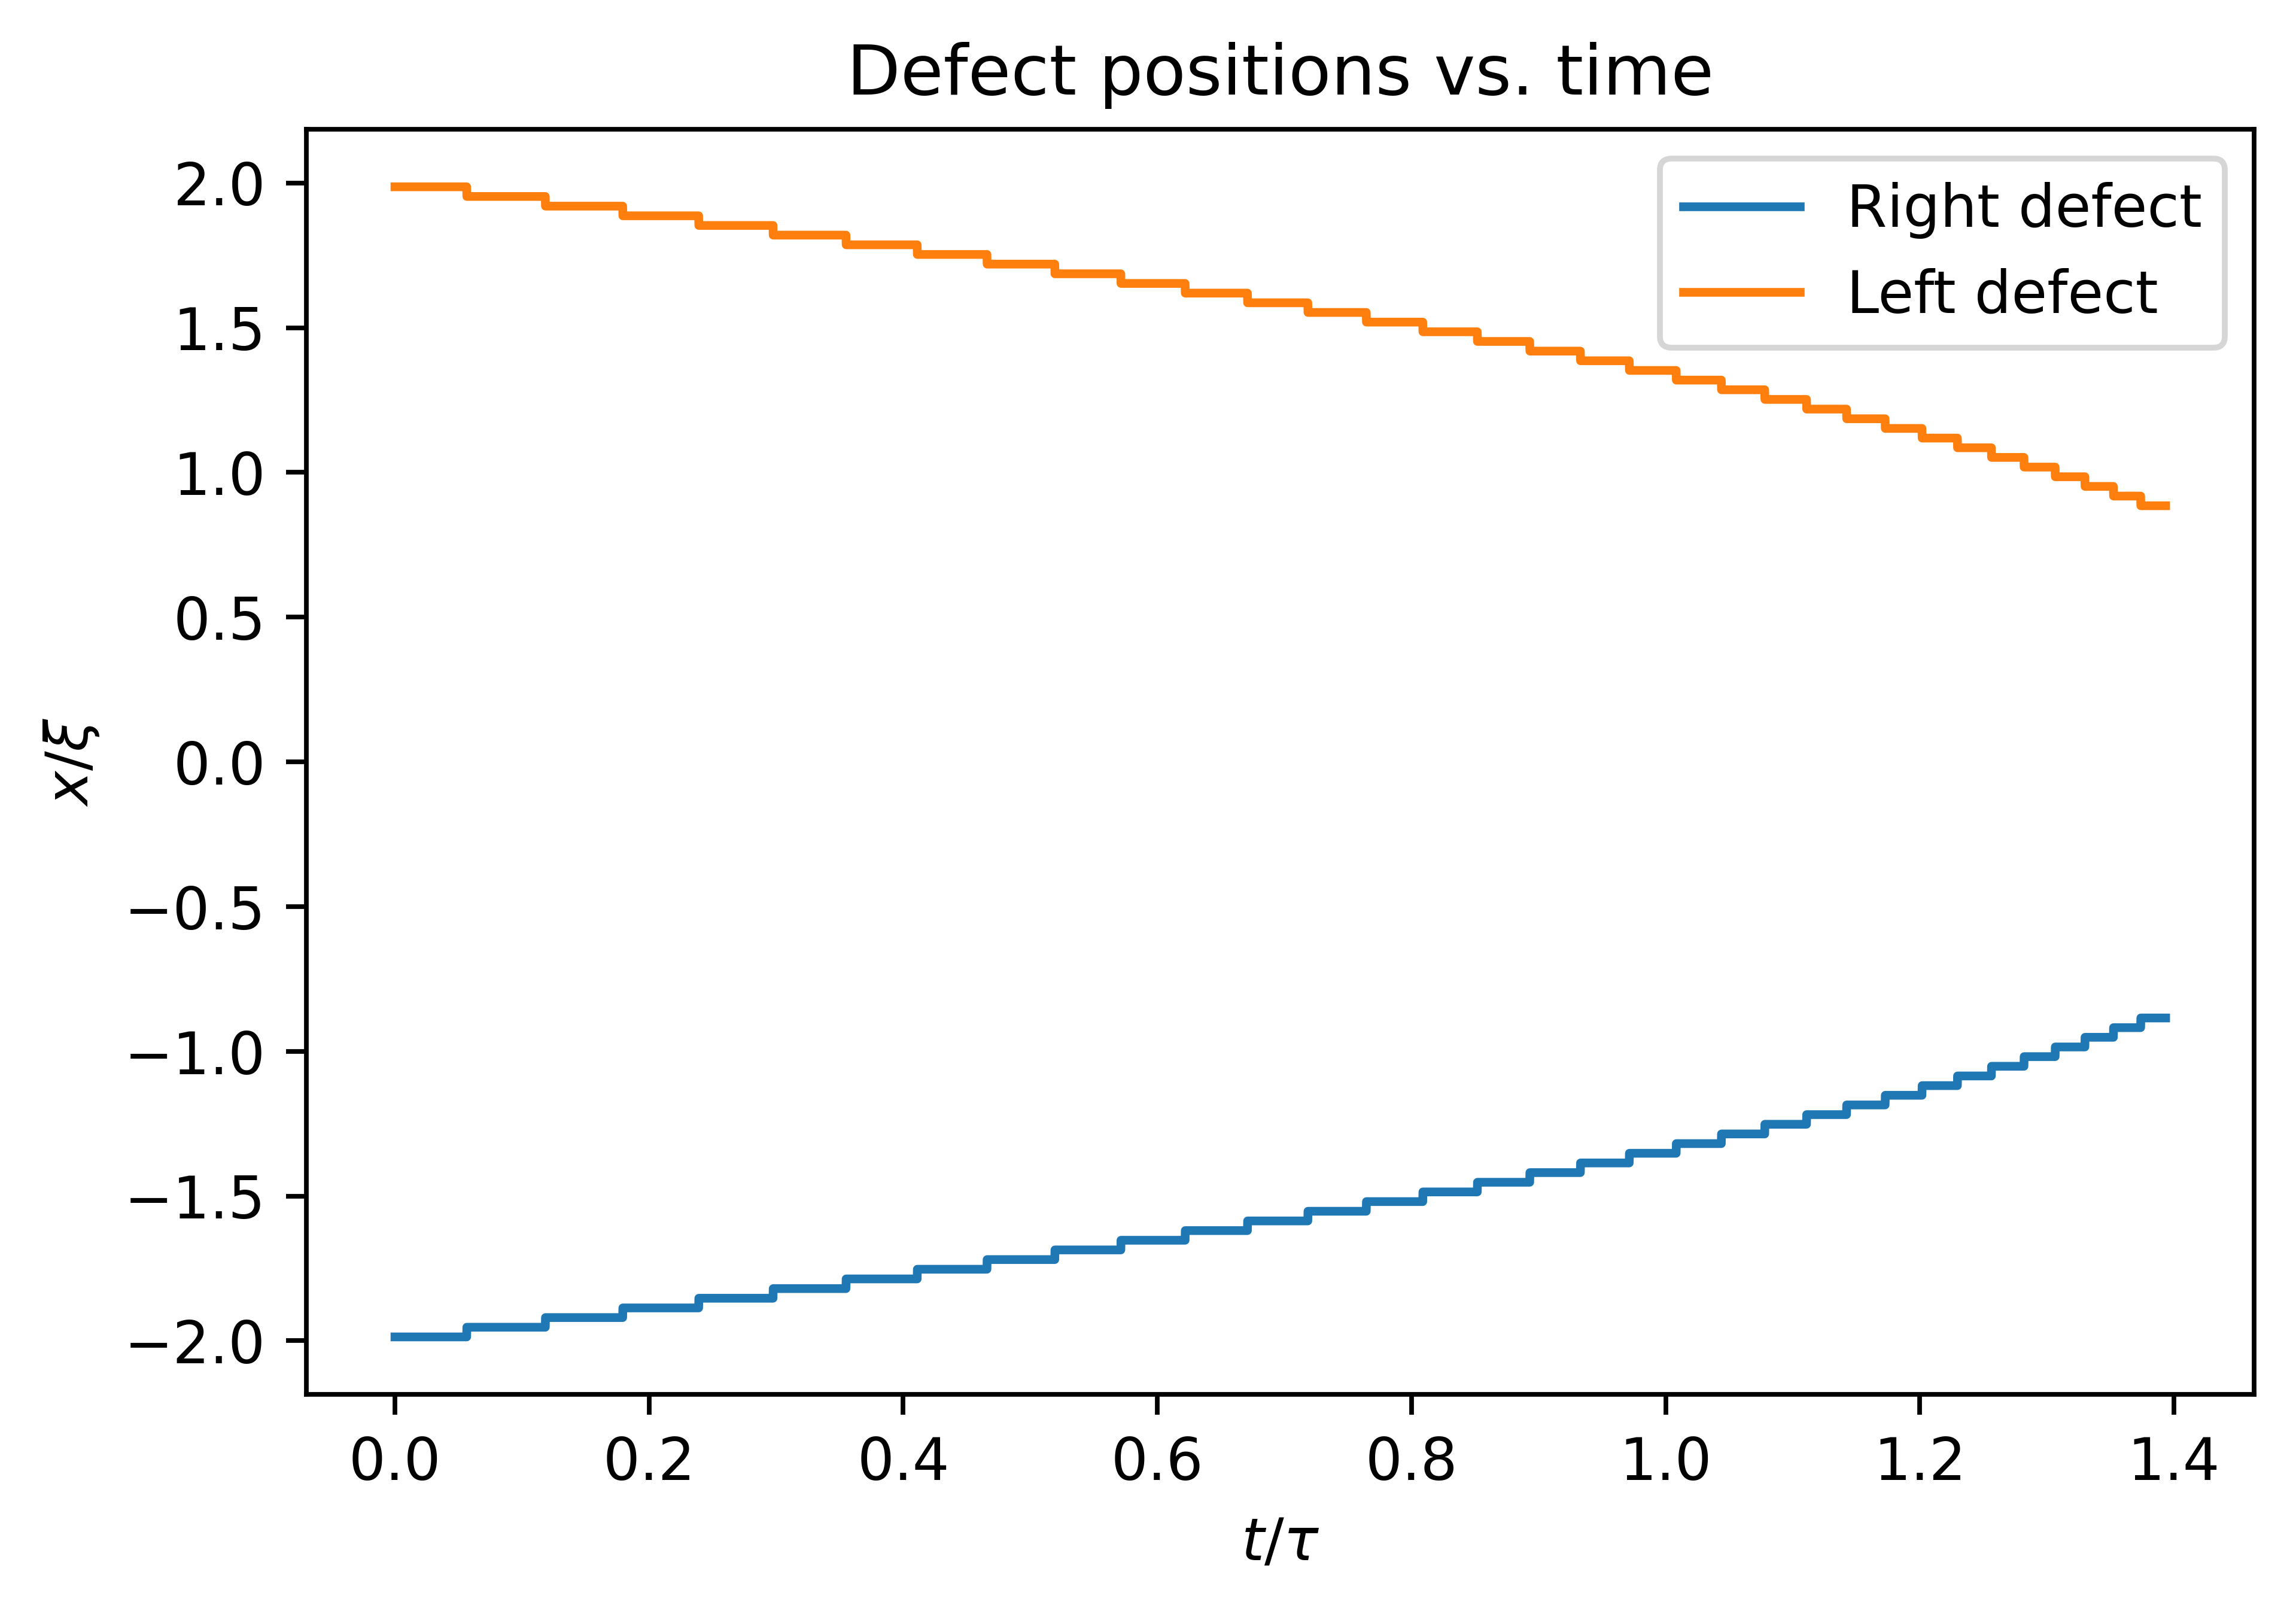

In [32]:
plt.plot(t, peak_pos[0, :], label="+1/2 defect")
plt.plot(t, peak_pos[1, :], label="-1/2 defect")
plt.title("Defect positions vs. time")
plt.xlabel(r"$t/\tau$")
plt.ylabel(r"$x/\xi$")
plt.legend()

plt.savefig("DefectPosVsTime600pts.png")

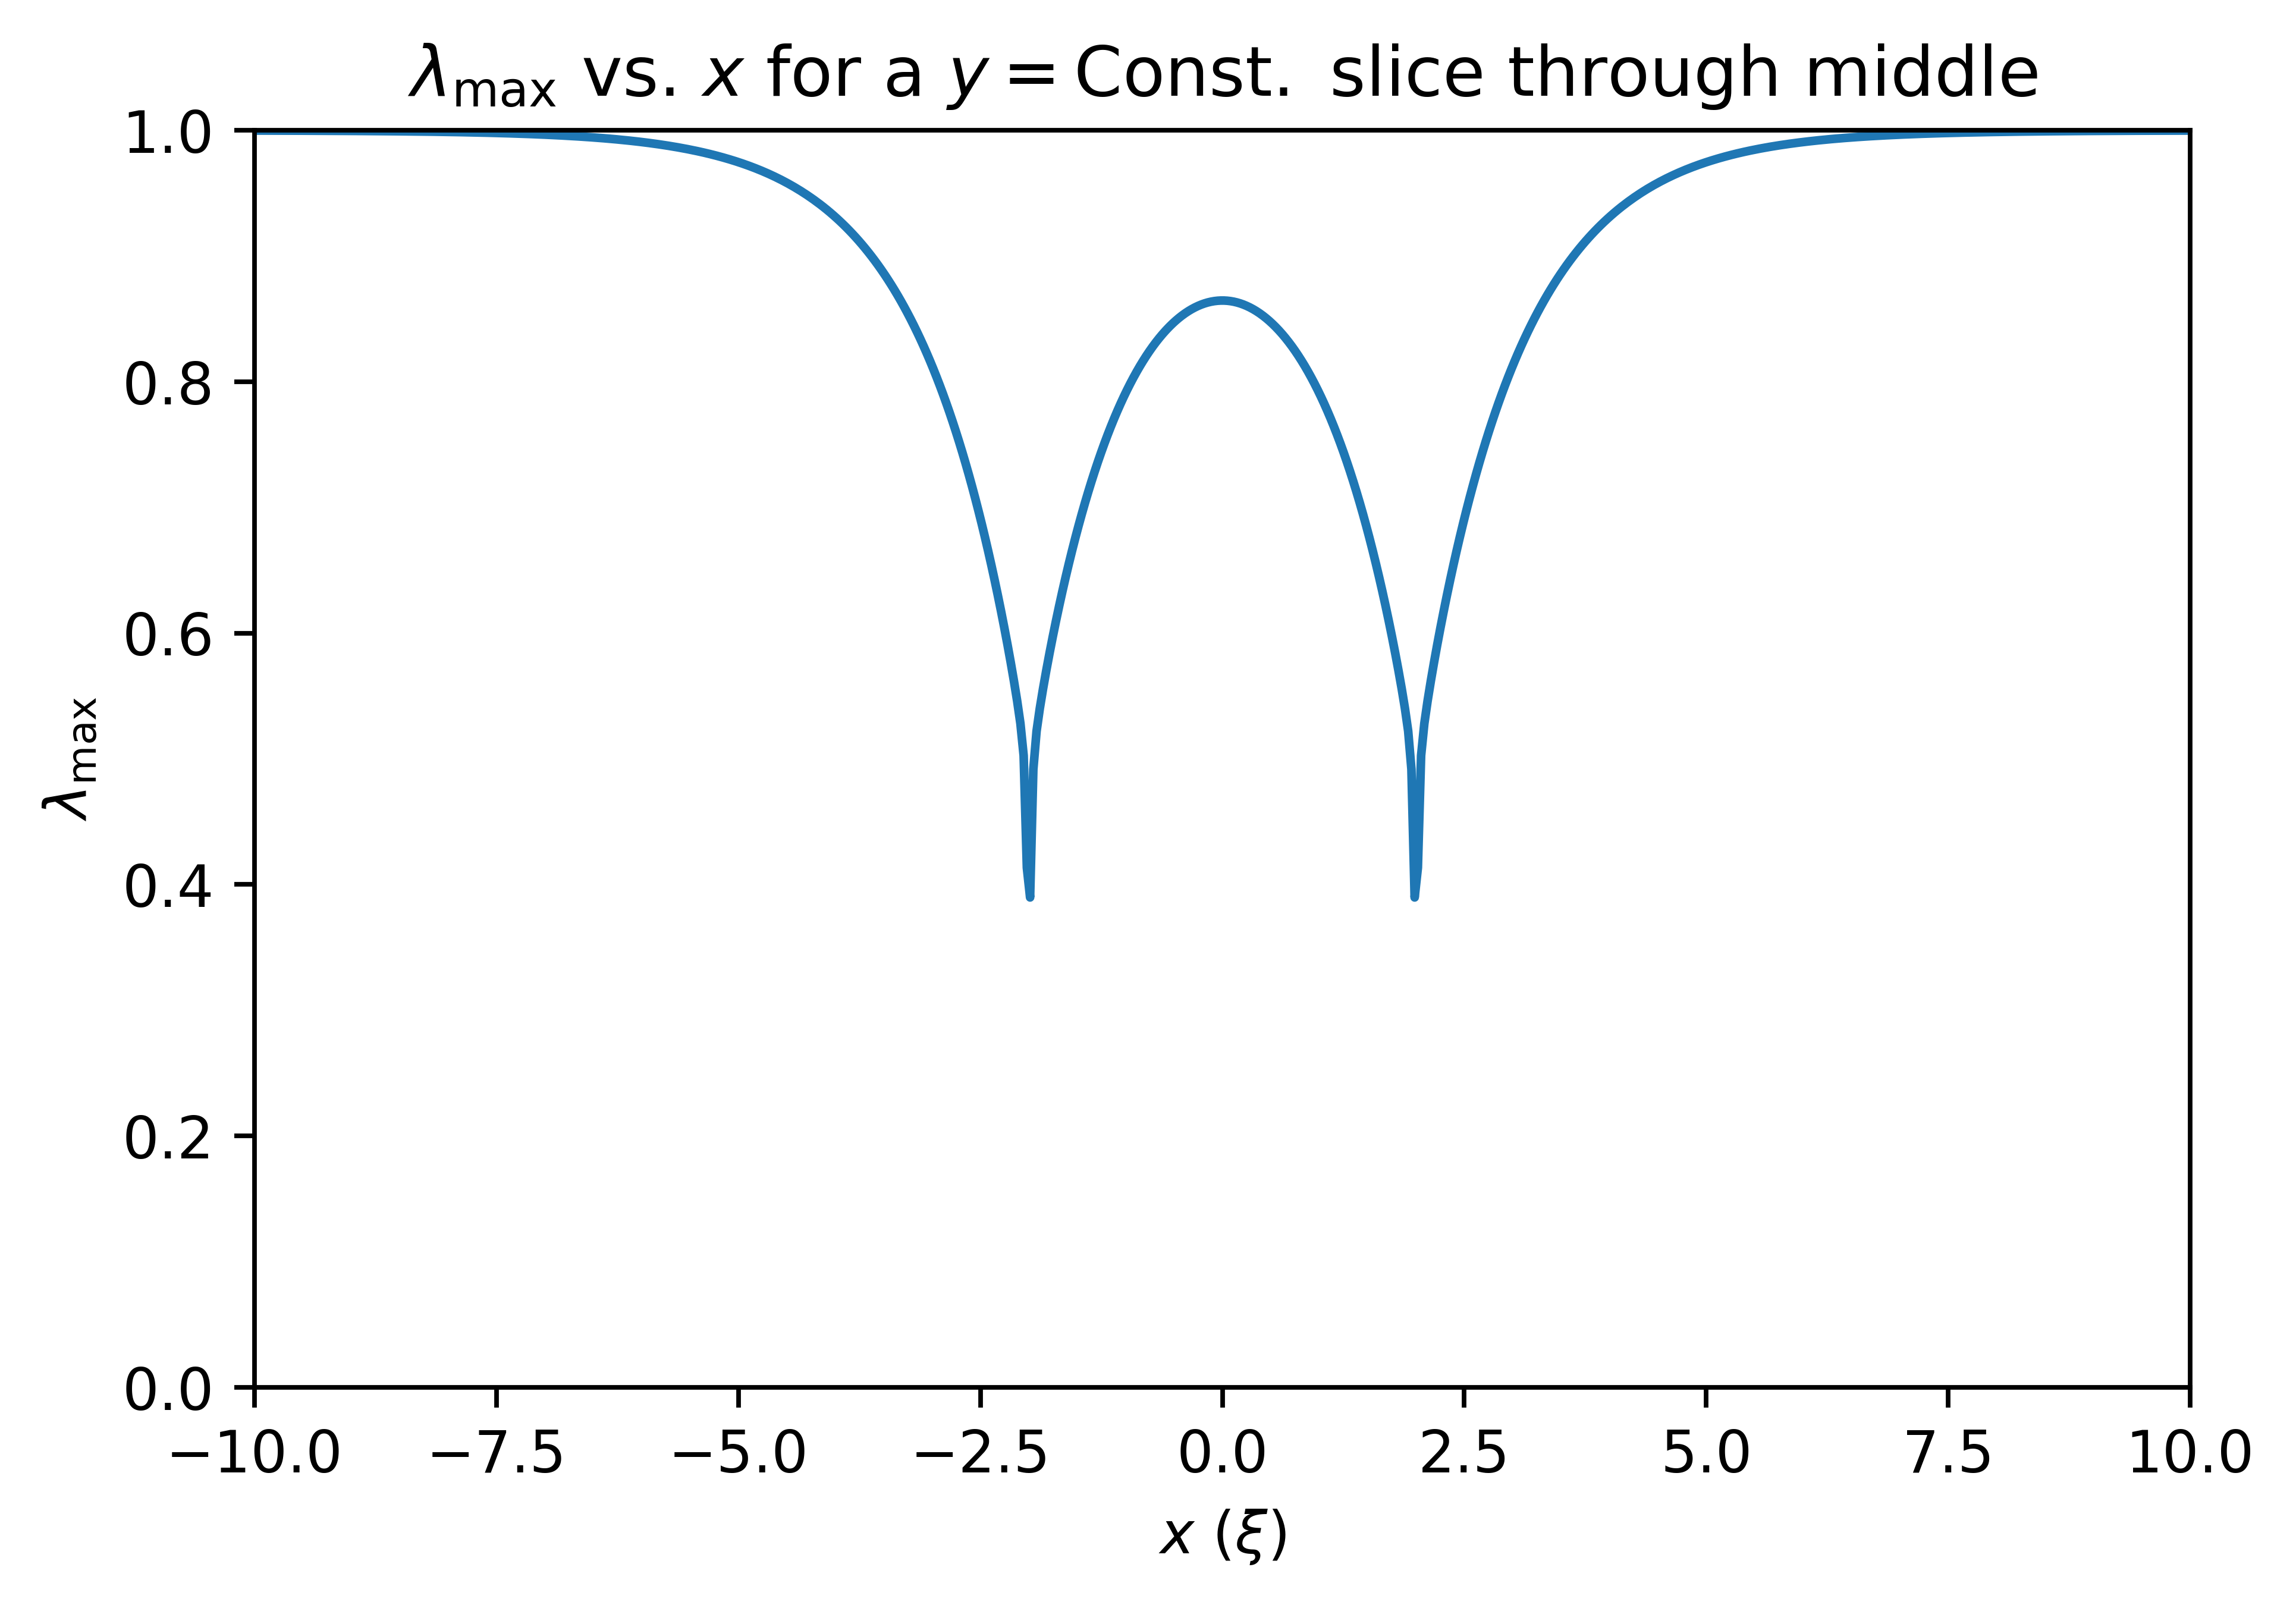

In [33]:
S_val = 1

fig, ax = plt.subplots()
xdata, ydata = X[:, middle], middle_slice[:, 0]
ln, = plt.plot(xdata, ydata)
plt.title(r"$\lambda_\mathrm{max}$ vs. $x$ for a $y = \mathrm{Const.}$ slice through middle")
plt.xlabel(r"$x$ ($\xi$)")
plt.ylabel(r"$\lambda_\mathrm{max}$")

def init(l=l, S_val=S_val):
    ax.set_xlim(-l, l)
    ax.set_ylim(0, S_val)
    return ln,

def update(frame, X=X, middle_slice=middle_slice, middle=middle):
    xdata = X[:, middle]
    ydata = middle_slice[:, frame]
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.arange(0, 5000),
                    init_func=init, interval=2, blit=True)
plt.show()

In [34]:
ani_start_time = time.perf_counter()
ani.save("MiddleSliceTimeEvolution600Pts.mp4", dpi=200)
ani_end_time = time.perf_counter()

print("Time to save animation is", (ani_end_time - ani_start_time)/60, "minutes")

Time to save animation is -21.93567561999989 minutes


In [248]:
Video("MiddleSliceTimeEvolution2.mp4")

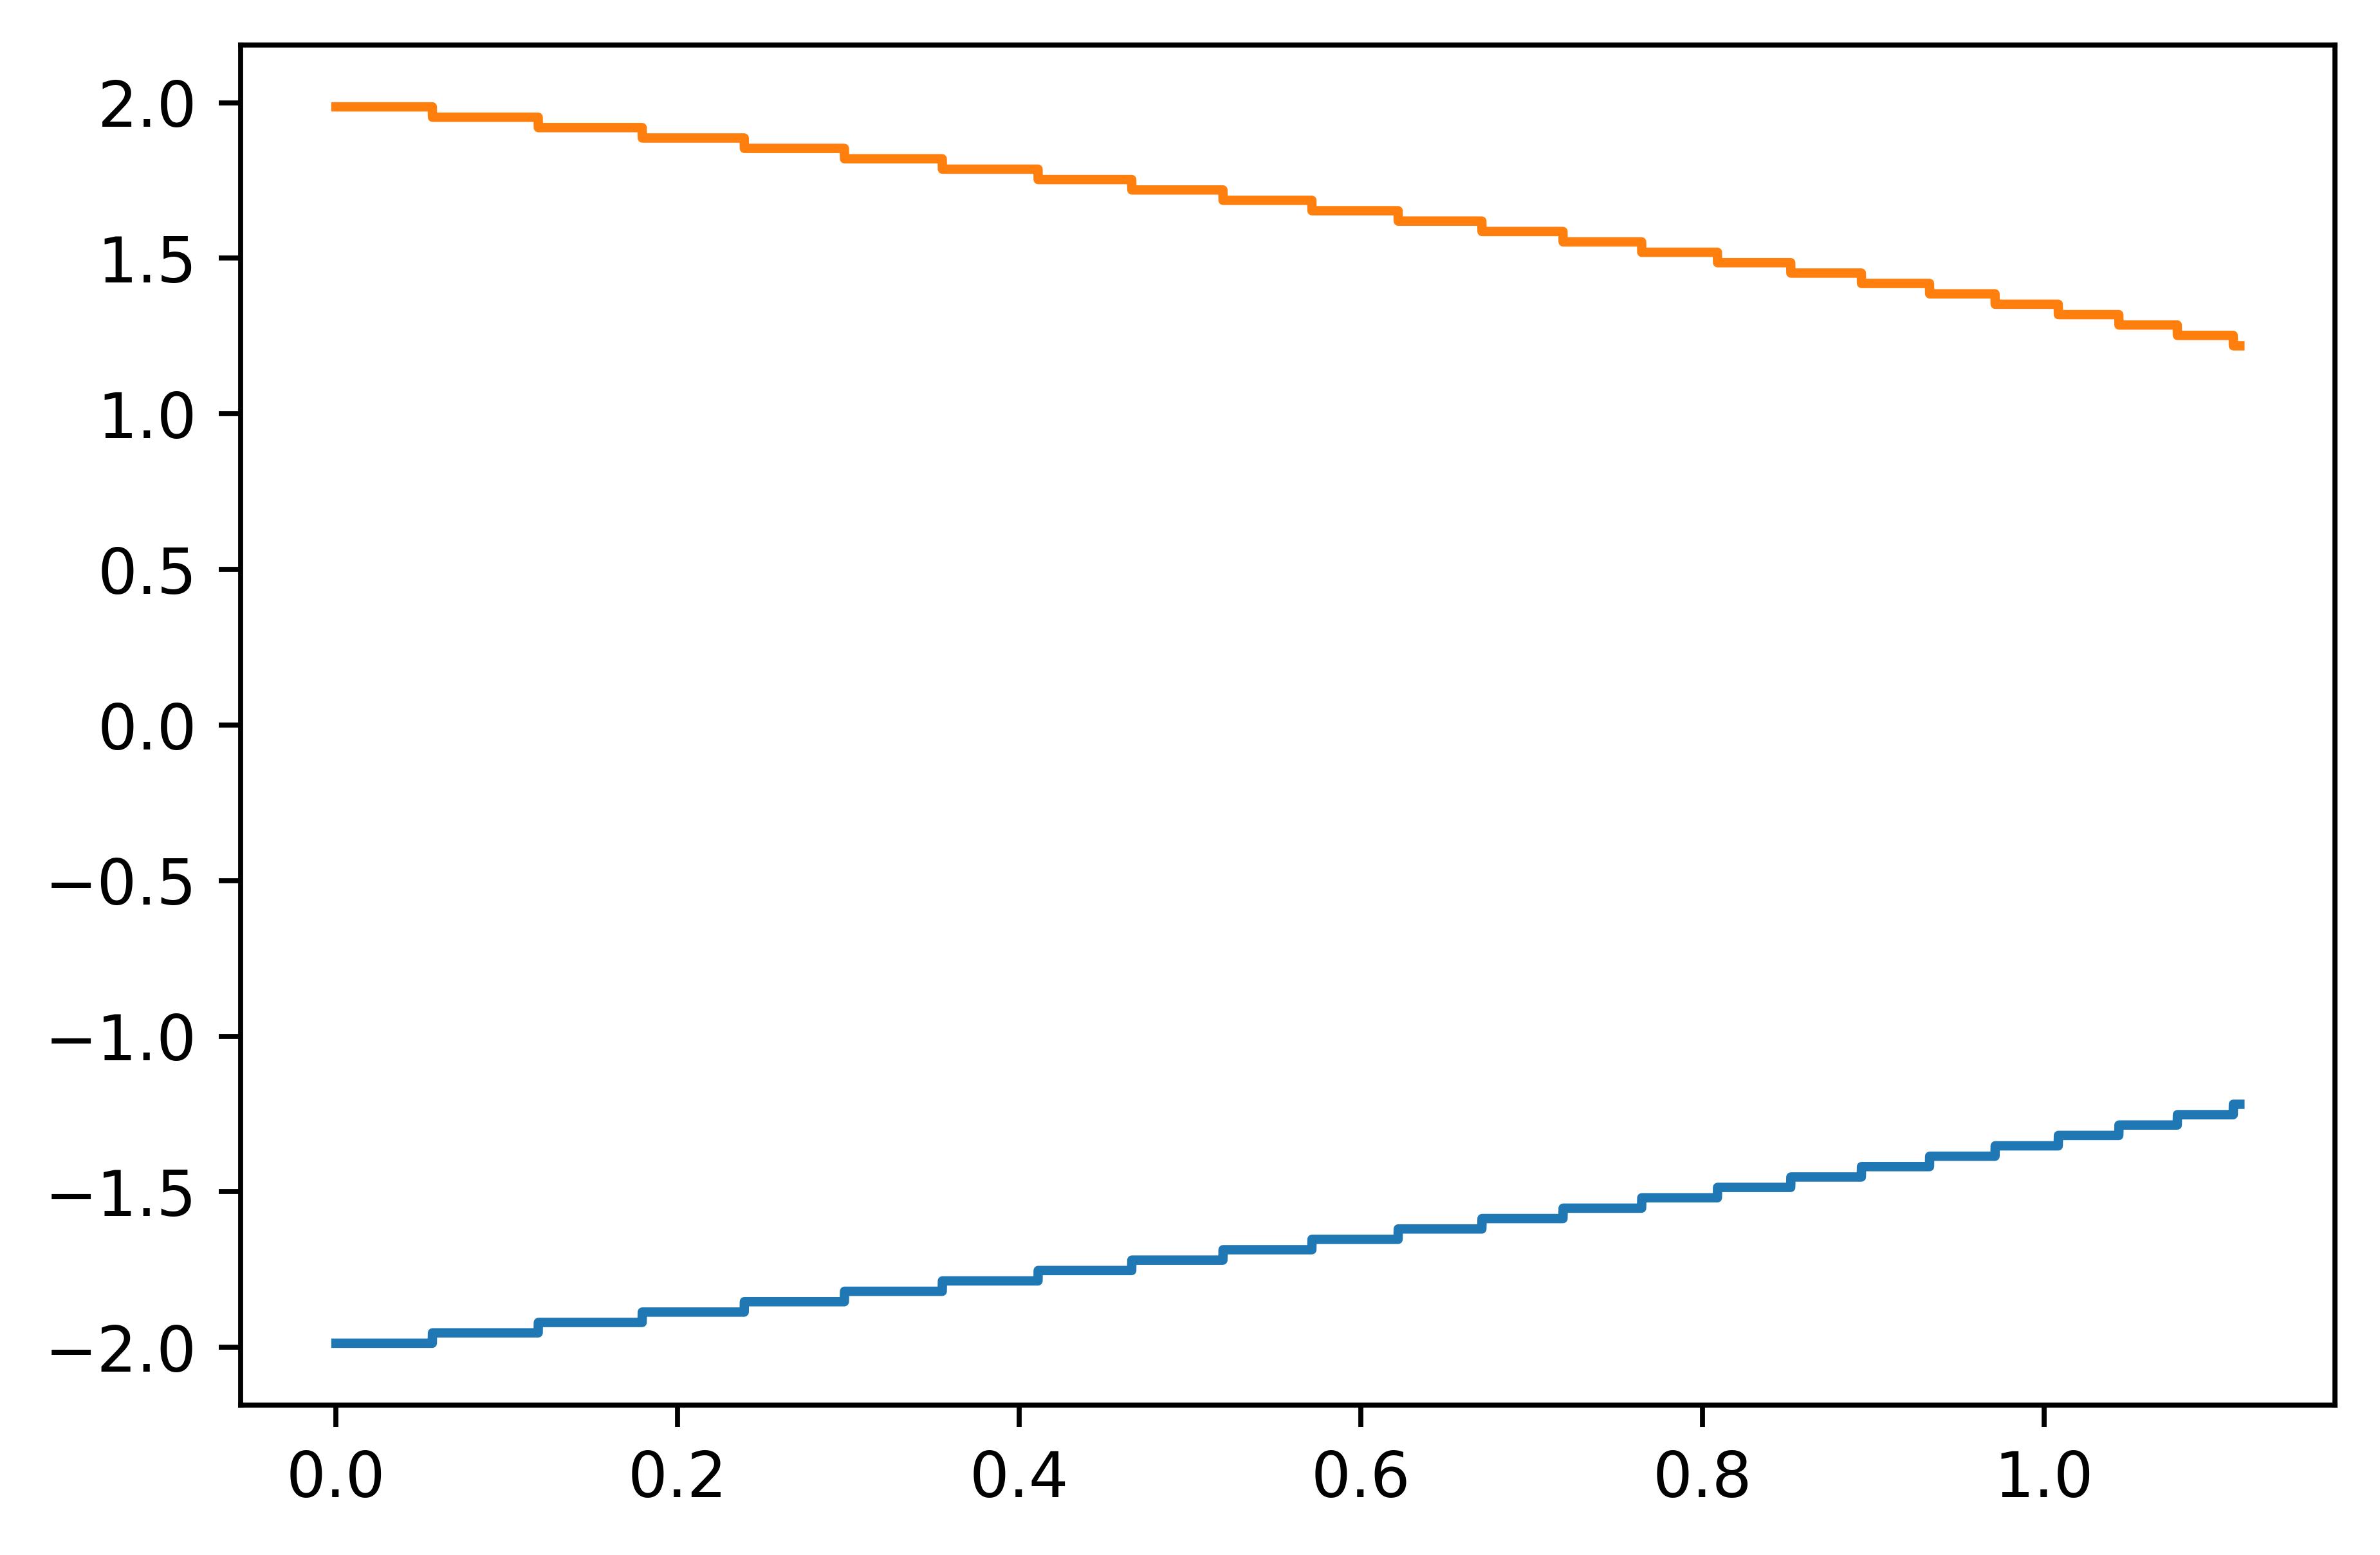

In [251]:
Image("DefectPositions600Pts.png")

-----

### Let's try it with 300 points, but half the step size (and double the steps)

In [8]:
l = 10
n = 300

x = np.linspace(-l, l, num=n)
y = np.linspace(-l, l, num=n)
X, Y = np.meshgrid(x, y, indexing='ij')

S_val = 0.5
ctr = [[-2, 0], [2, 0]]
r = [1, 1]
m = [-1/2, 1/2]

S, phi = lch.makeMultiDisclination(X, Y, S_val, ctr, r, m)
Q = lch.uniaxialQ(S, phi)
eta, mu, nu = lch.auxVars(Q)

In [9]:
dx = X[1, 0] - X[0, 0]
dy = Y[0, 1] - Y[0, 0]

# This is just what they said it should be for stability
dt = dx**2/32

num_steps = 20000
peak_pos = np.zeros((2, num_steps))
t = np.zeros(num_steps)
widths = np.arange(0, 1.5, 0.05)

middle = np.floor(n/2).astype('int')
middle_slice = np.zeros((n, num_steps))

eta_old = eta
mu_old = mu
nu_old = nu

# Create loading bar
progress = widgets.IntProgress(min=0, max=num_steps)
display(progress)

start_time = time.perf_counter()
for i in range(num_steps):
    
    eta_new = fd.forwardEuler(eta_old, dt, lch.etaEOM, mu_old, nu_old, dx, dy)
    mu_new = fd.forwardEuler(mu_old, dt, lch.muEOM, eta_old, nu_old, dx, dy)
    nu_new = fd.forwardEuler(nu_old, dt, lch.nuEOM, eta_old, mu_old, dx, dy)
    
    eta_old = eta_new
    mu_old = mu_new
    nu_old = nu_new
    
    lambda_max = lch.calcQEigenvals(eta_old, mu_old, nu_old)
    peaks, _ = find_peaks(-lambda_max[:, middle])
    peak_pos[:, i] = X[peaks, middle]
    
    middle_slice[:, i] = lambda_max[:, middle]
    
    t[i] = i*dt
    
    # Update loading bar
    progress.value = i
    
end_time = time.perf_counter()
print("Total time elapsed is", (end_time - start_time)/60, "minutes")

IntProgress(value=0, max=20000)

Total time elapsed is 4.033435261666667 minutes


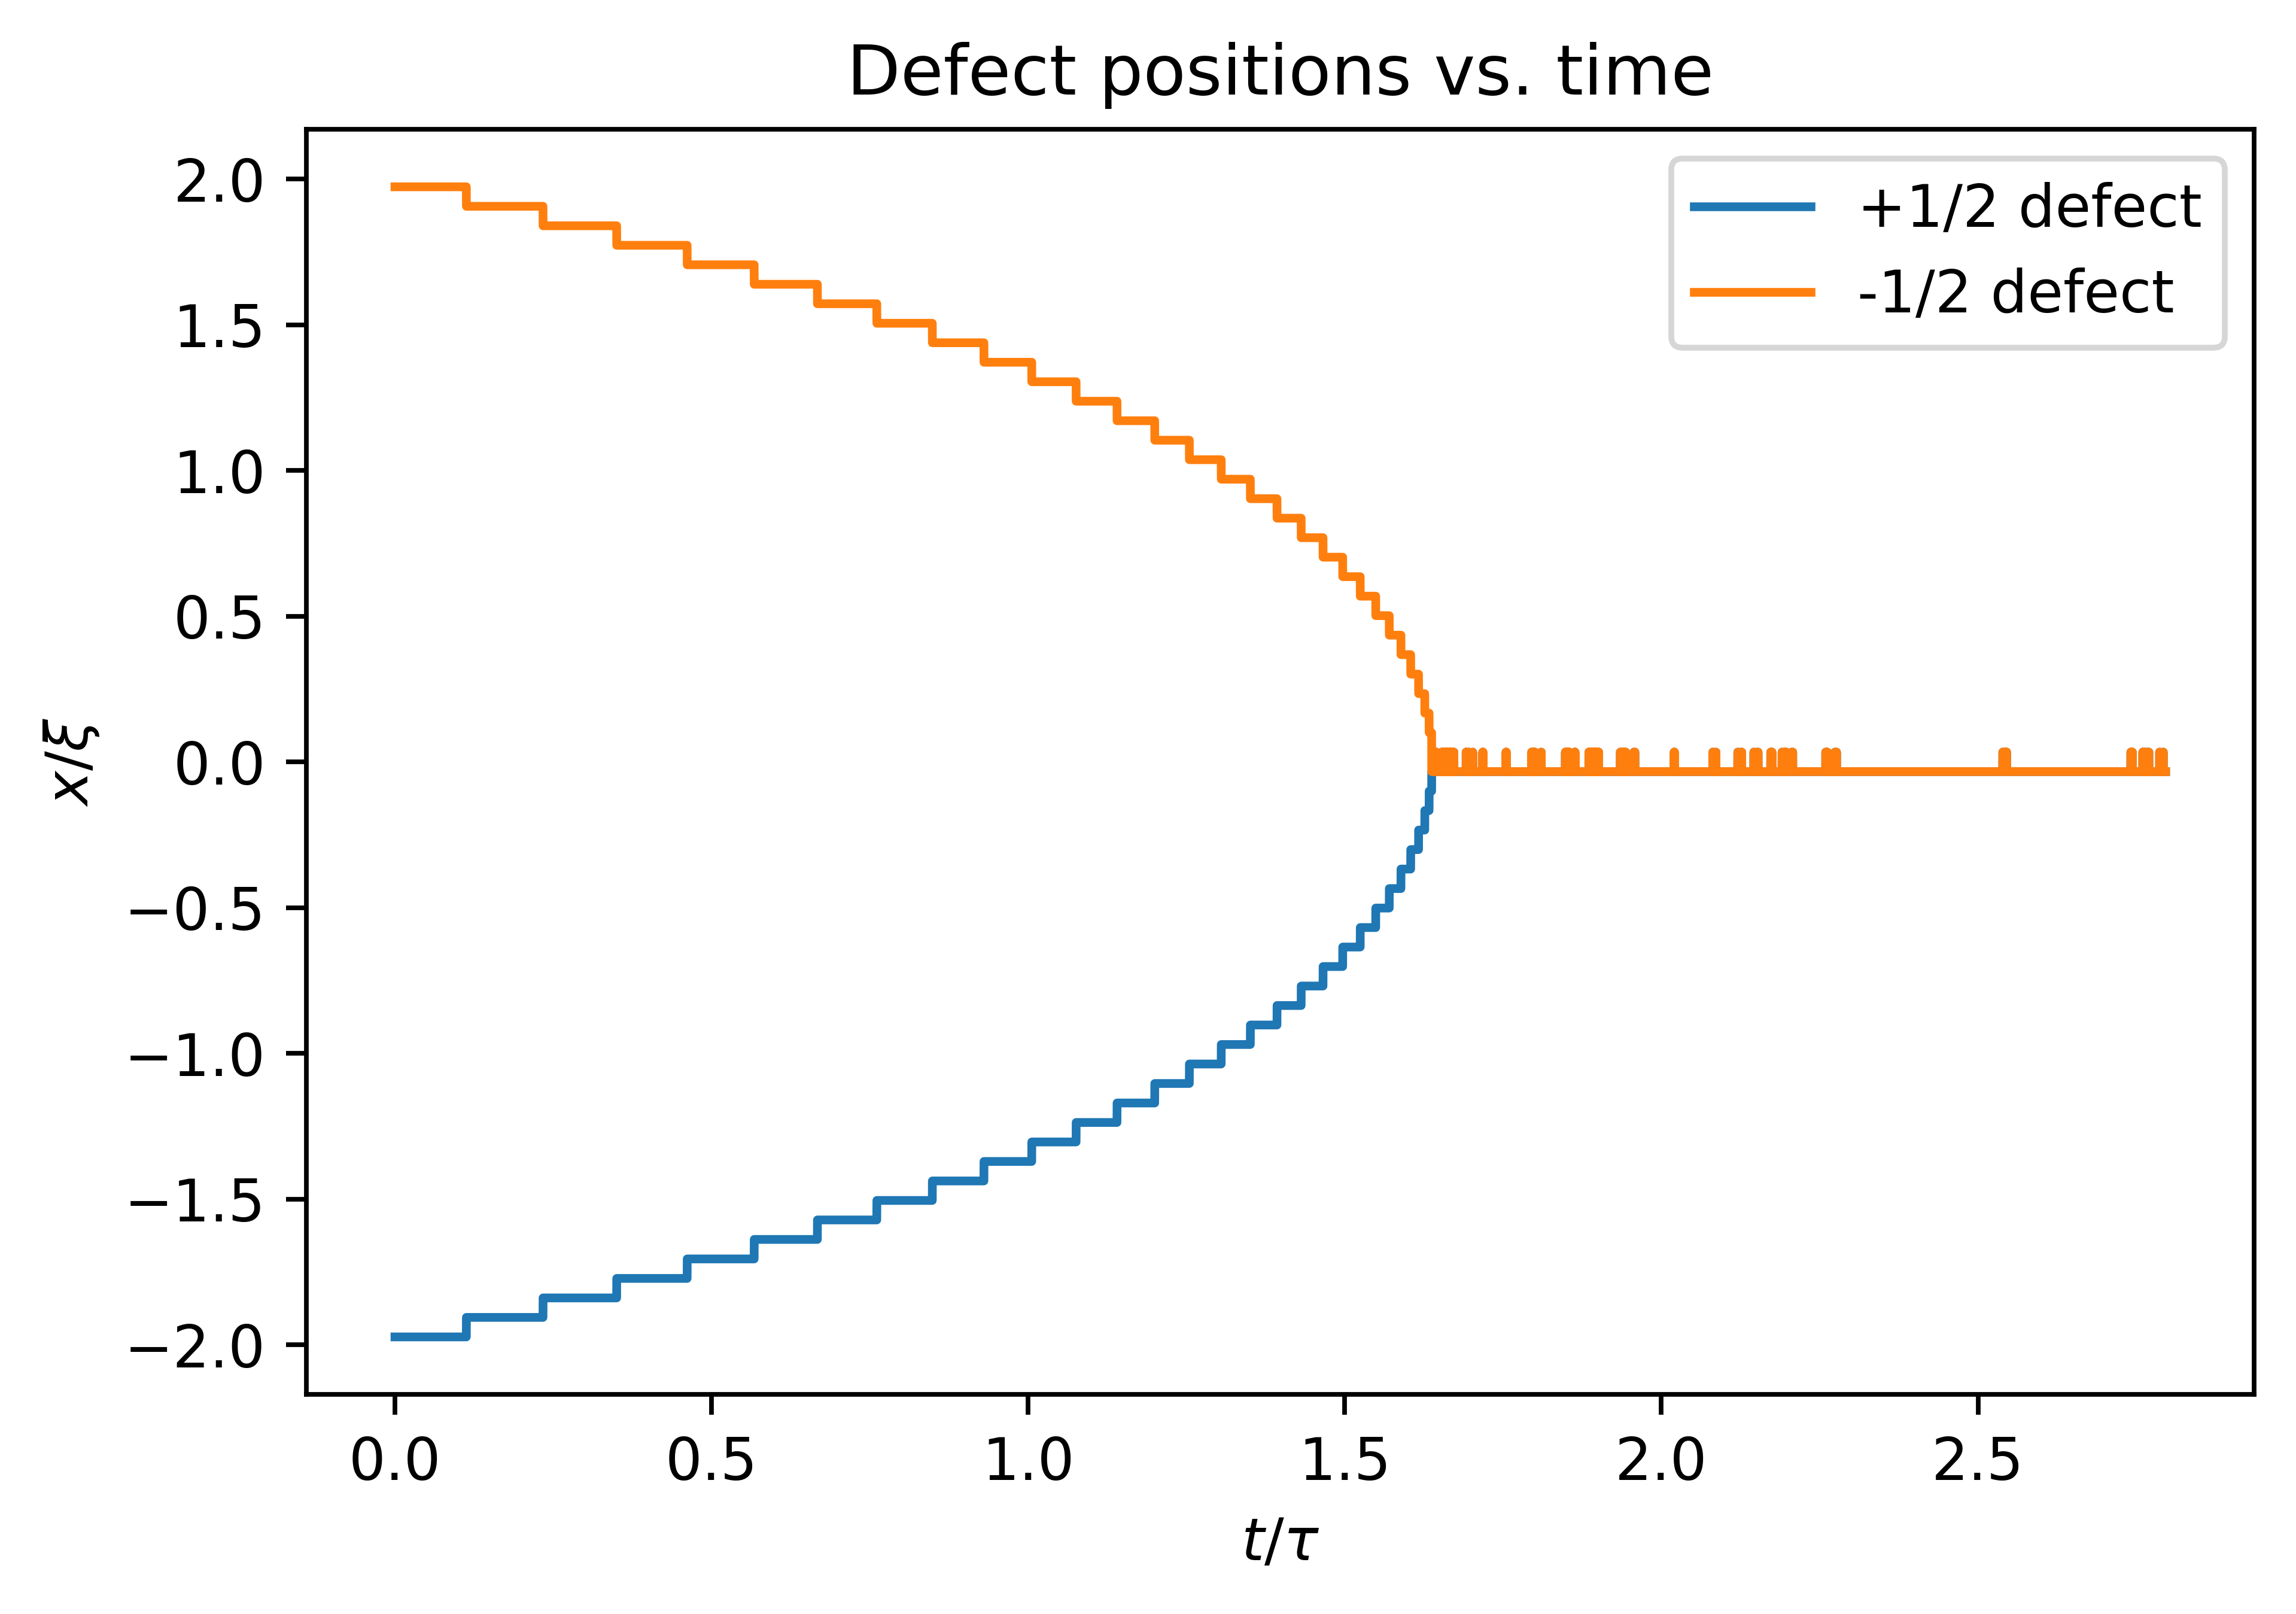

In [10]:
plt.plot(t, peak_pos[0, :], label="+1/2 defect")
plt.plot(t, peak_pos[1, :], label="-1/2 defect")
plt.title("Defect positions vs. time")
plt.xlabel(r"$t/\tau$")
plt.ylabel(r"$x/\xi$")
plt.legend()

plt.savefig("DefectPosVsTime300ptsHalfTimestep.png")

### When I actually look at this animation, there's some weird rolling that happens at the minima -- basically there's two points to each minimum, and one is closer to the middle, so when the closer one drops below the $S$ value of the further one, you get a quick jump as shown in the plot below.

### Before I do anything, I ought to try to add more data points to see if it smooths things out.
* It looks like it smooths it out some, but not as much as I want.
*  Should try a less pointy starting configuration. 
* If that doesn't work I'll need to do some smoothing business.

### Also might try to add a sweeping line across the plot below to make sure the jumps correspond to what I think they do. 

---------------

### I wonder if Svensek and Zumer got away from this by just leaving $S$ as a constant -- then maybe the configuration relaxed in a reasonable way to make the minima smooth at the bottom. Either way, I'm gonna need to figure out some way to deal with this. 

In [267]:
l = 10
n = 600

x = np.linspace(-l, l, num=n)
y = np.linspace(-l, l, num=n)
X, Y = np.meshgrid(x, y, indexing='ij')

In [268]:
S_val = 1
ctr = [[-2, 0], [2, 0]]
r = [1, 1]
m = [-1/2, 1/2]

S, phi = lch.makeMultiDisclination(X, Y, S_val, ctr, r, m, decay=False)
Q = lch.uniaxialQ(S, phi)
eta, mu, nu = lch.auxVars(Q)

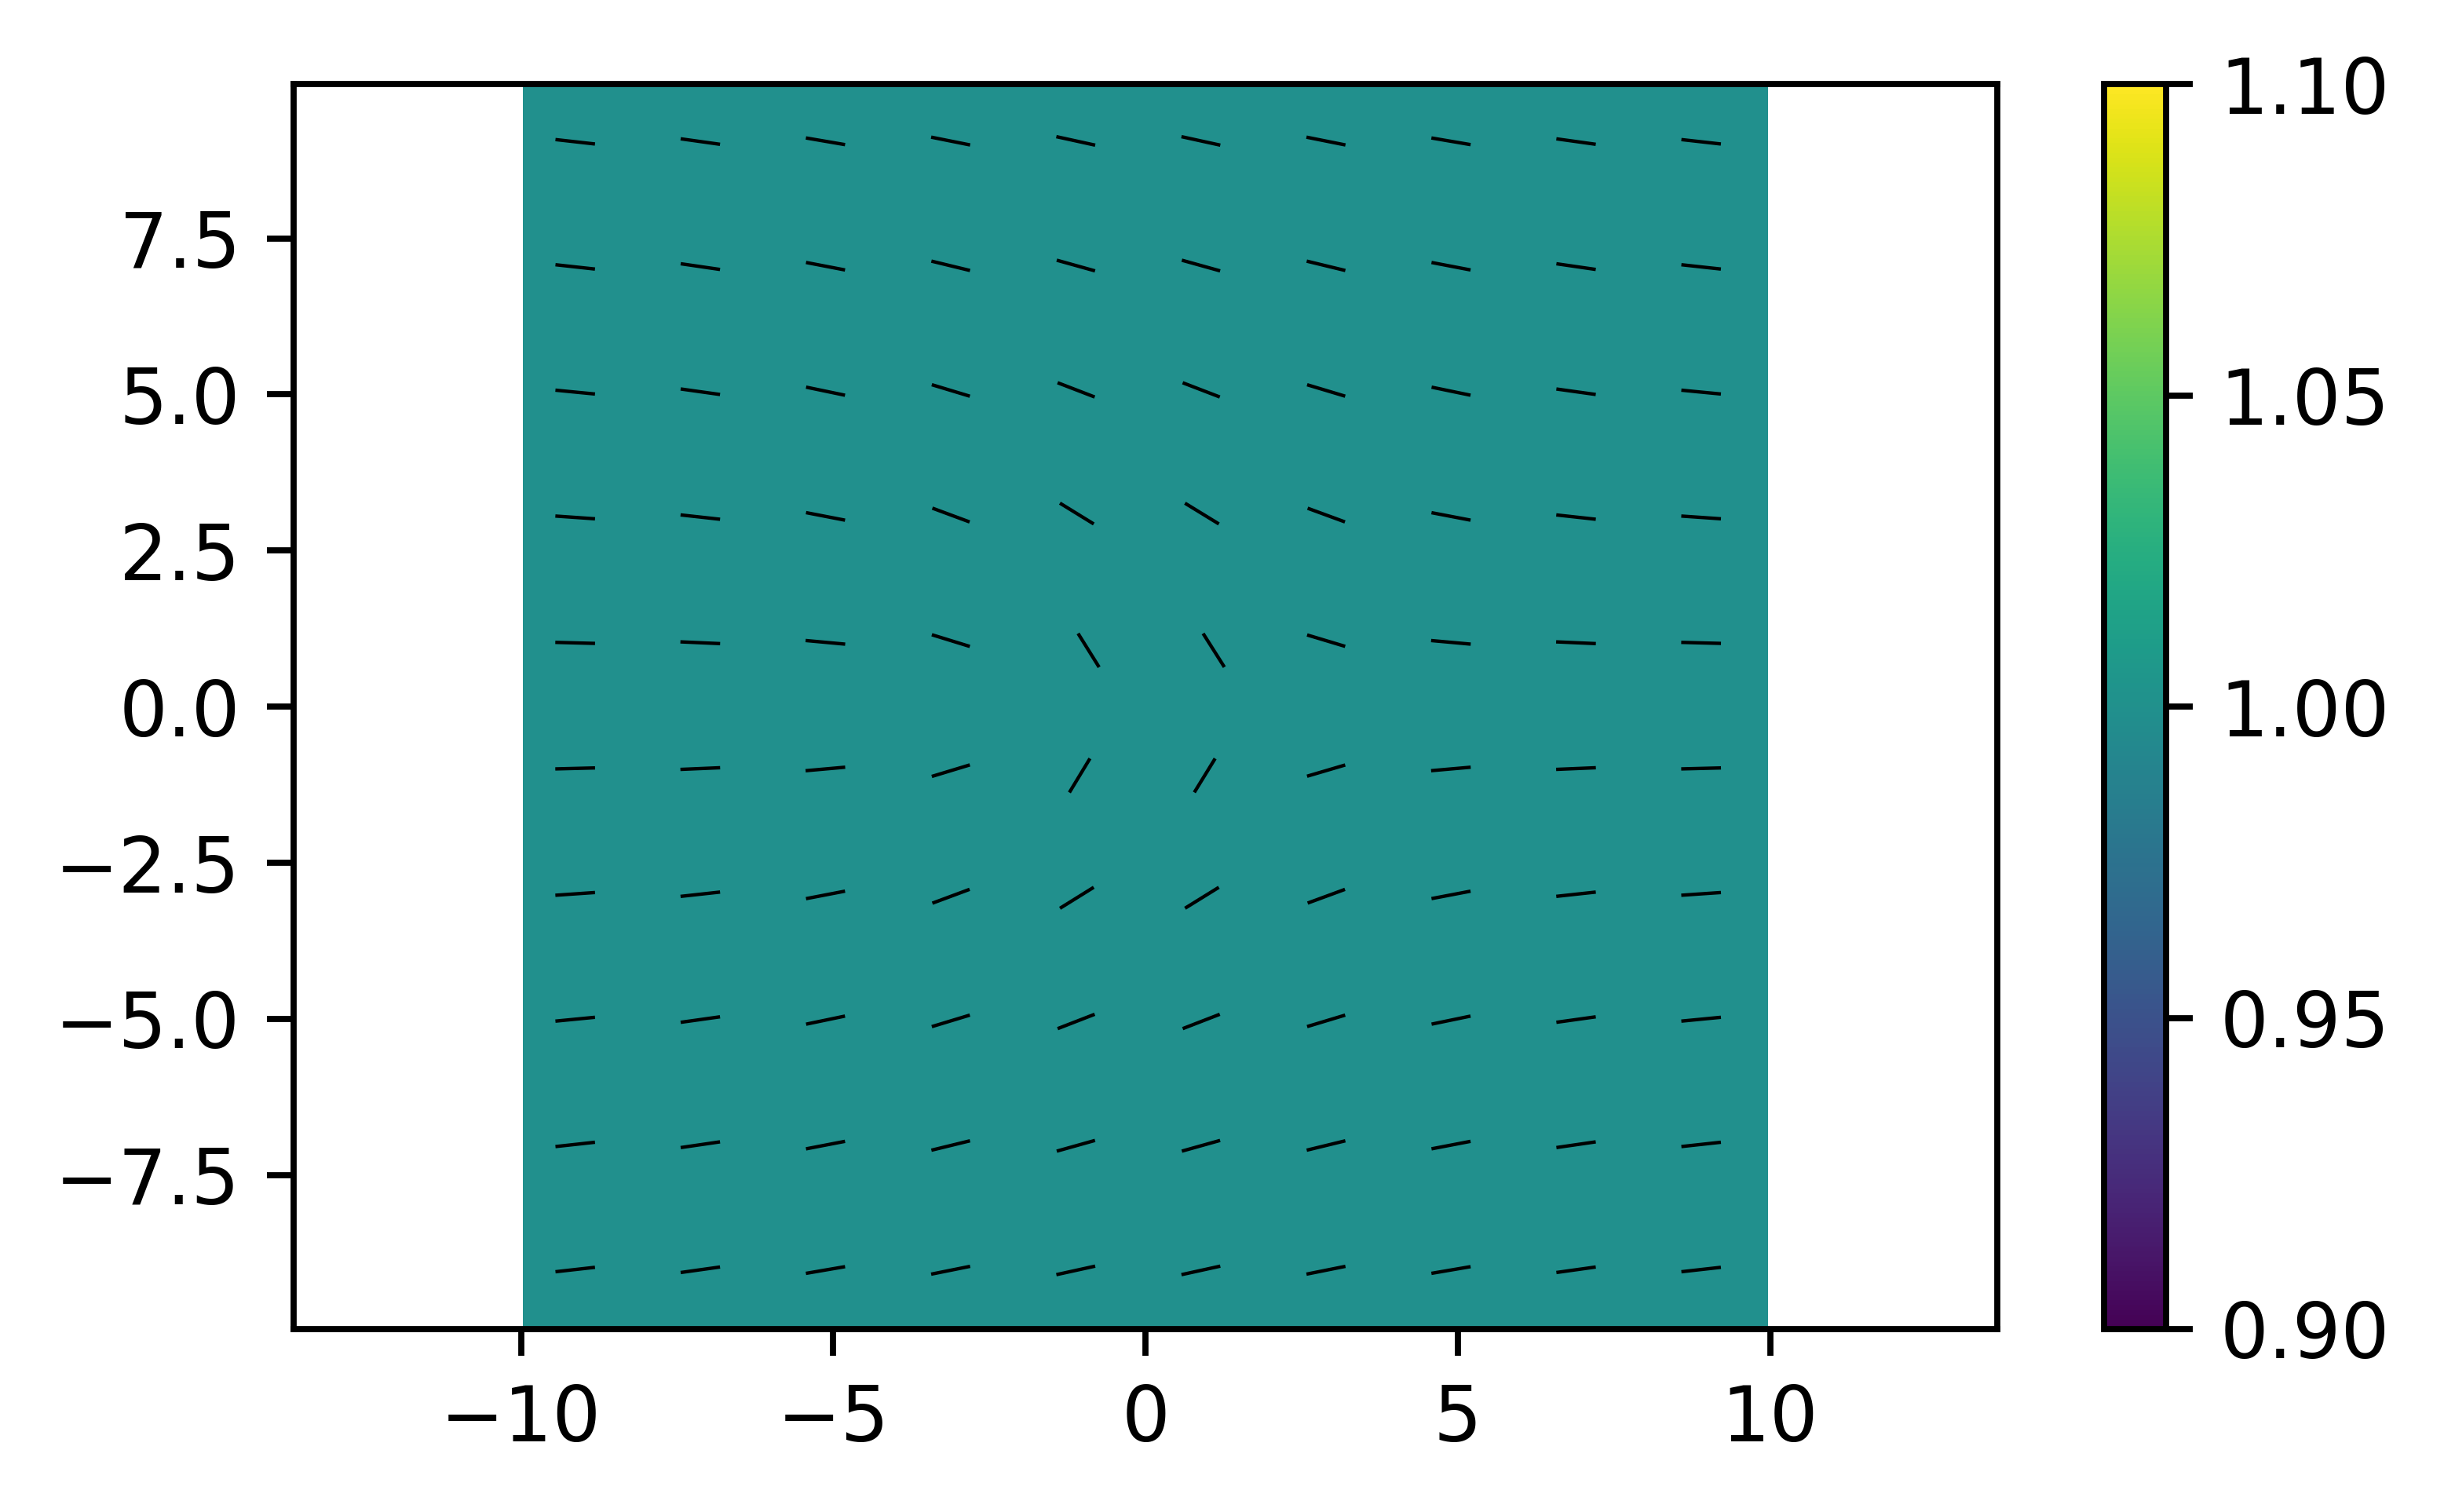

In [269]:
sparse_shape = (10, 10)
S_sparse_shape = (200, 200)
S_cutoff = 0.3

lambda_pm = lch.calcQEigenvals(eta, mu, nu)
U, V = lch.calcQEigenvecs(eta, mu, nu, lambda_pm, S_cutoff)

sparse_idx = lch.sparseIdx(Q[0, 0].shape, sparse_shape)
S_sparse_idx = lch.sparseIdx(Q[0, 0].shape, S_sparse_shape)

fig, ax = plt.subplots(figsize=(5, 3))
c = ax.pcolor(X[S_sparse_idx], Y[S_sparse_idx], S[S_sparse_idx])
q = ax.quiver(X[sparse_idx], Y[sparse_idx], U[sparse_idx], V[sparse_idx],
              headwidth=0, pivot='middle', headaxislength=5, scale=30, width=0.002)
ax.quiverkey(q, X=0.3, Y=1.1, U=10,
             label='Quiver key, length = 10', labelpos='E')
ax.axis('equal')
fig.colorbar(c, ax=ax)

In [270]:
num_steps = 10000
peak_pos = np.zeros((2, num_steps))
t = np.zeros(num_steps)
widths = np.arange(0, 1.5, 0.05)

middle_slice = np.zeros((n, num_steps))
middle = np.floor(n/2).astype('int')

eta_old = eta
mu_old = mu
nu_old = nu

# Create loading bar
progress = widgets.IntProgress(min=0, max=num_steps)
display(progress)

for i in range(num_steps):
    
    eta_new = fd.forwardEuler(eta_old, dt, lch.etaEOM, mu_old, nu_old, dx, dy)
    mu_new = fd.forwardEuler(mu_old, dt, lch.muEOM, eta_old, nu_old, dx, dy)
    nu_new = fd.forwardEuler(nu_old, dt, lch.nuEOM, eta_old, mu_old, dx, dy)
    
    eta_old = eta_new
    mu_old = mu_new
    nu_old = nu_new
    
    lambda_pm = lch.calcQEigenvals(eta_old, mu_old, nu_old)
    peaks, _ = find_peaks(-lambda_pm[:, middle])
    peak_pos[:, i] = X[peaks, middle]
    
    middle_slice[:, i] = lambda_pm[:, middle]
    
    t[i] = i*dt
    
    # Update loading bar
    progress.value = i


IntProgress(value=0, max=10000)

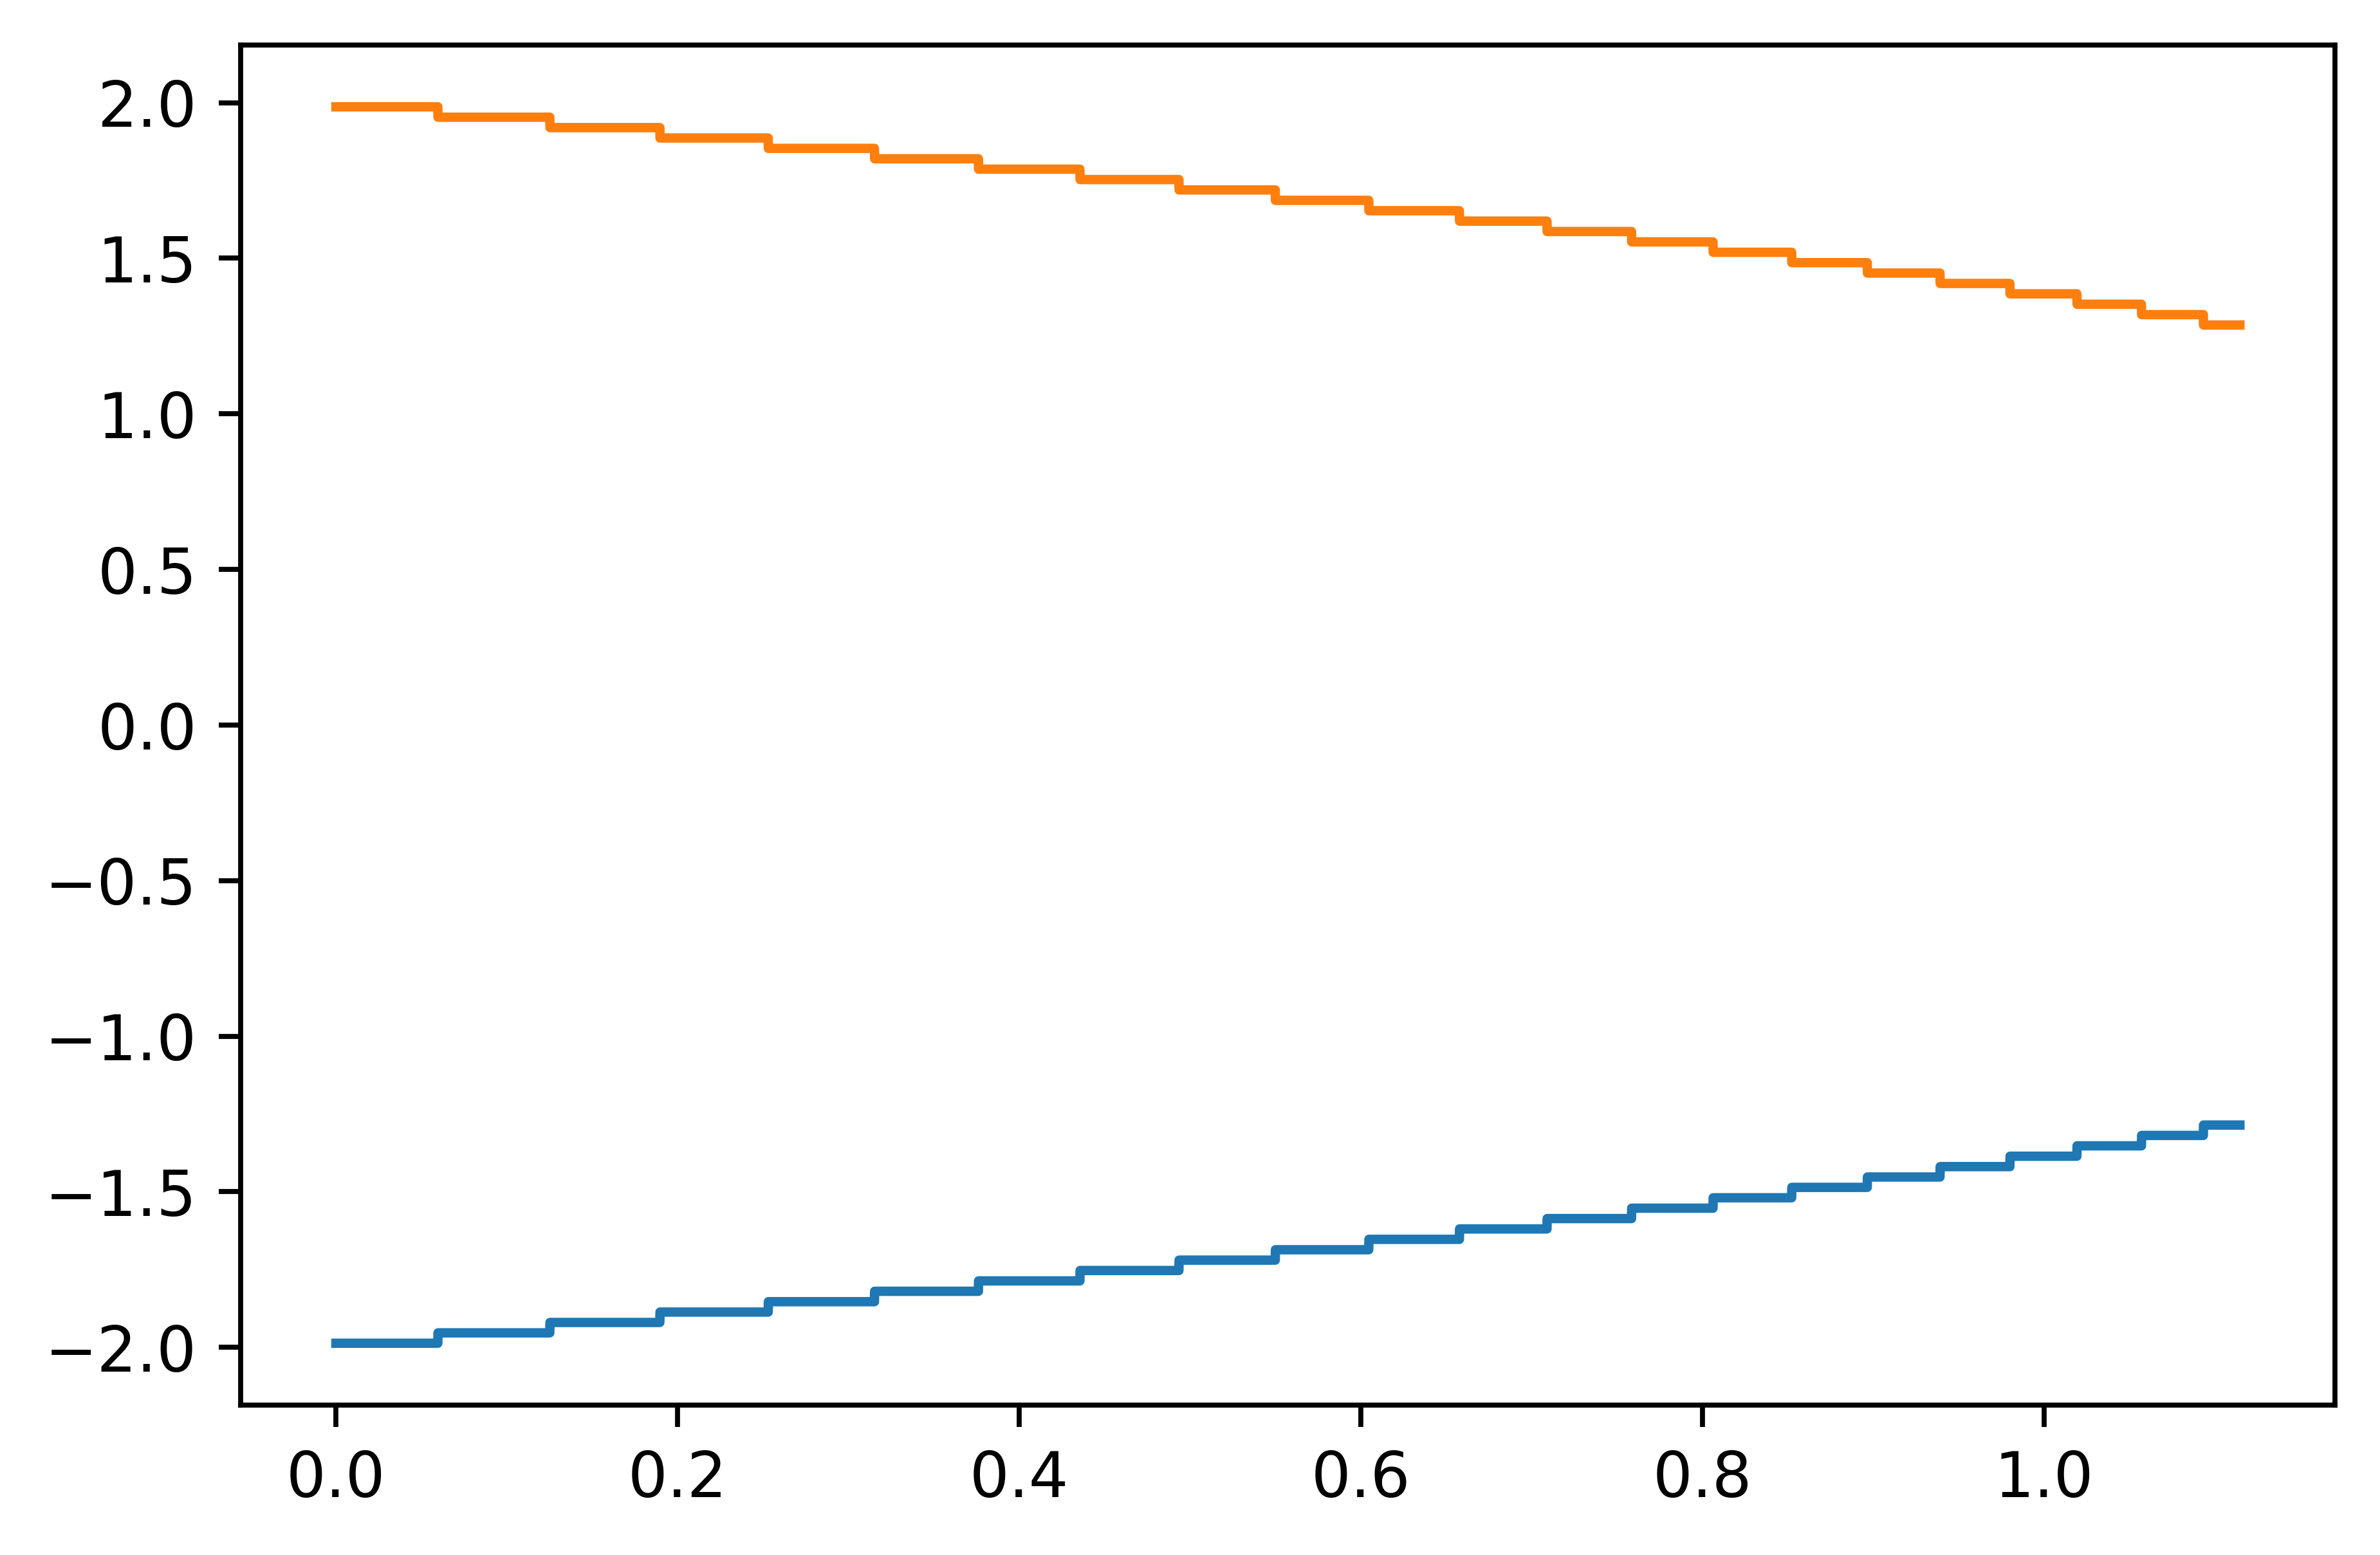

In [271]:
plt.plot(t, peak_pos[0, :])
plt.plot(t, peak_pos[1, :])

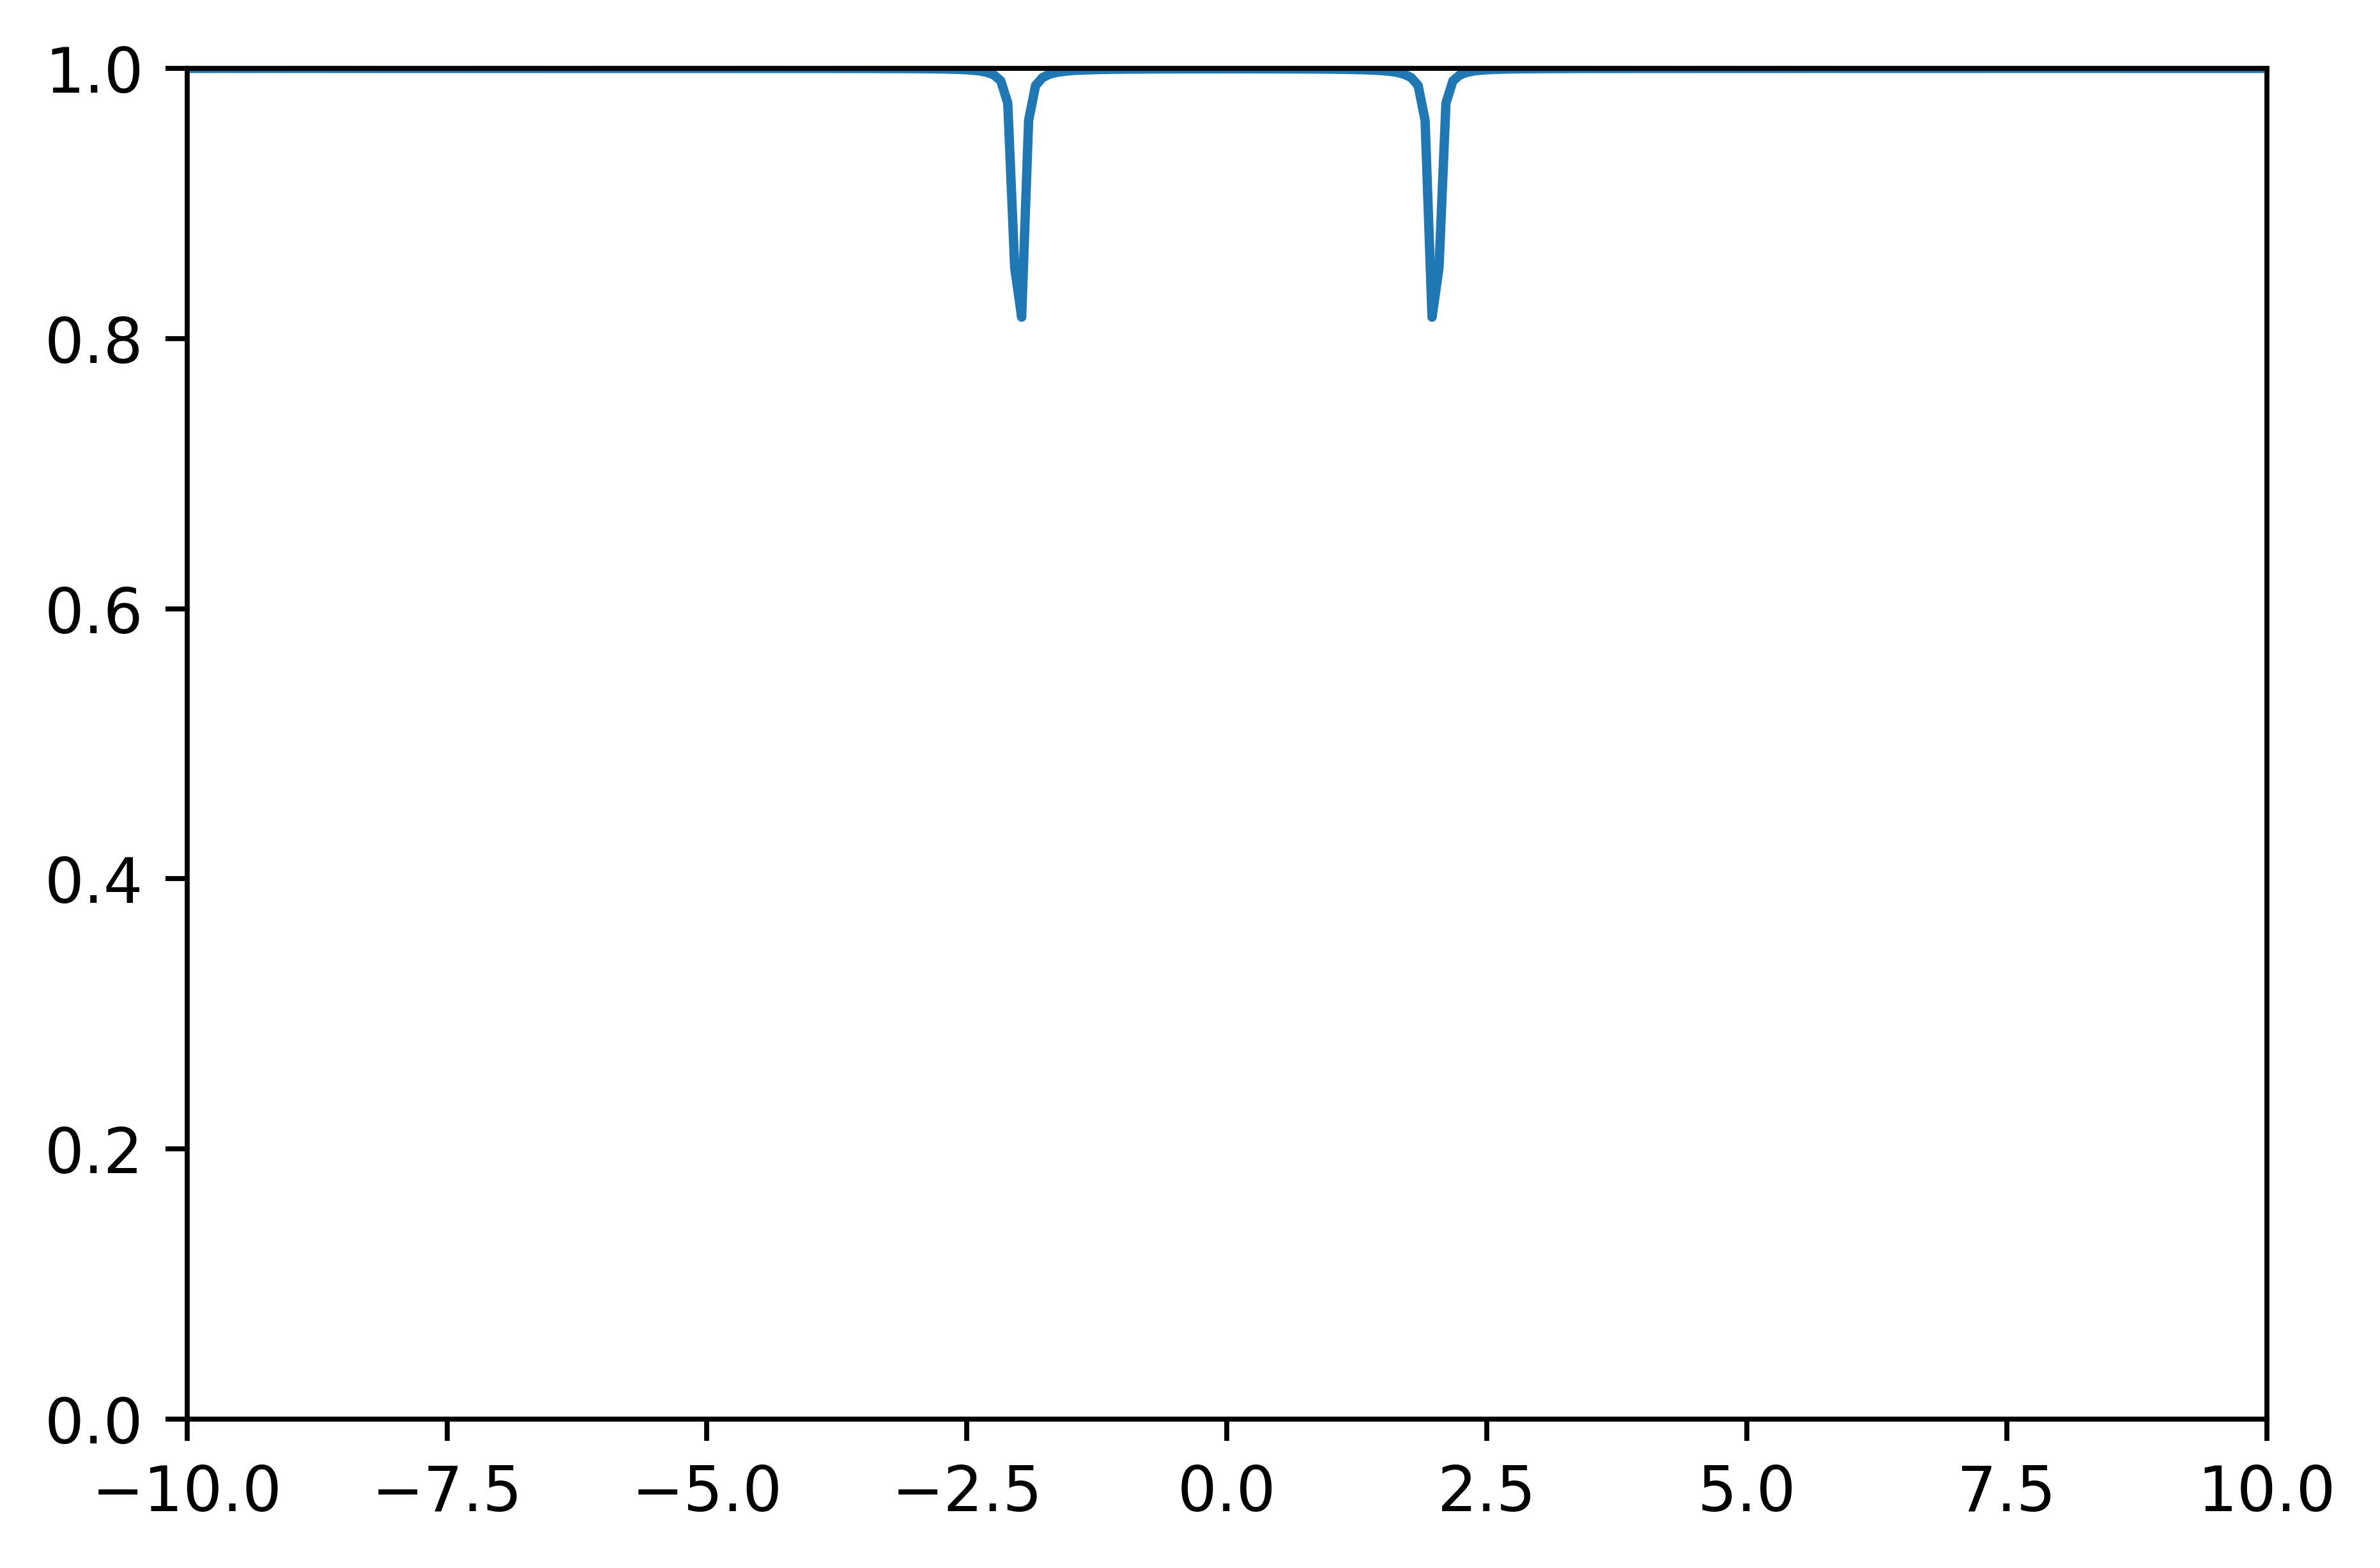

In [265]:
S_val = 1

fig, ax = plt.subplots()
xdata, ydata = X[:, middle], middle_slice[:, 0]
ln, = plt.plot(xdata, ydata)

def init(l=l, S_val=S_val):
    ax.set_xlim(-l, l)
    ax.set_ylim(0, S_val)
    return ln,

def update(frame, X=X, middle_slice=middle_slice, middle=middle):
    xdata = X[:, middle]
    ydata = middle_slice[:, frame]
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.arange(0, 5000),
                    init_func=init, interval=2, blit=True)
plt.show()

In [266]:
ani.save("MiddleSliceTimeEvolutionNoDecay.mp4", dpi=200)

---------

### Last thing before I totally buy into this smoothing business: Need to (a) find the 2D minima (rather than just assuming they're in the middle), and then see if their positions are smoother.

In [274]:
l = 10
n = 600

x = np.linspace(-l, l, num=n)
y = np.linspace(-l, l, num=n)
X, Y = np.meshgrid(x, y, indexing='ij')

In [272]:
S_val = 0.5
ctr = [[-2, 0], [2, 0]]
r = [1, 1]
m = [-1/2, 1/2]

S, phi = lch.makeMultiDisclination(X, Y, S_val, ctr, r, m)
Q = lch.uniaxialQ(S, phi)
eta, mu, nu = lch.auxVars(Q)

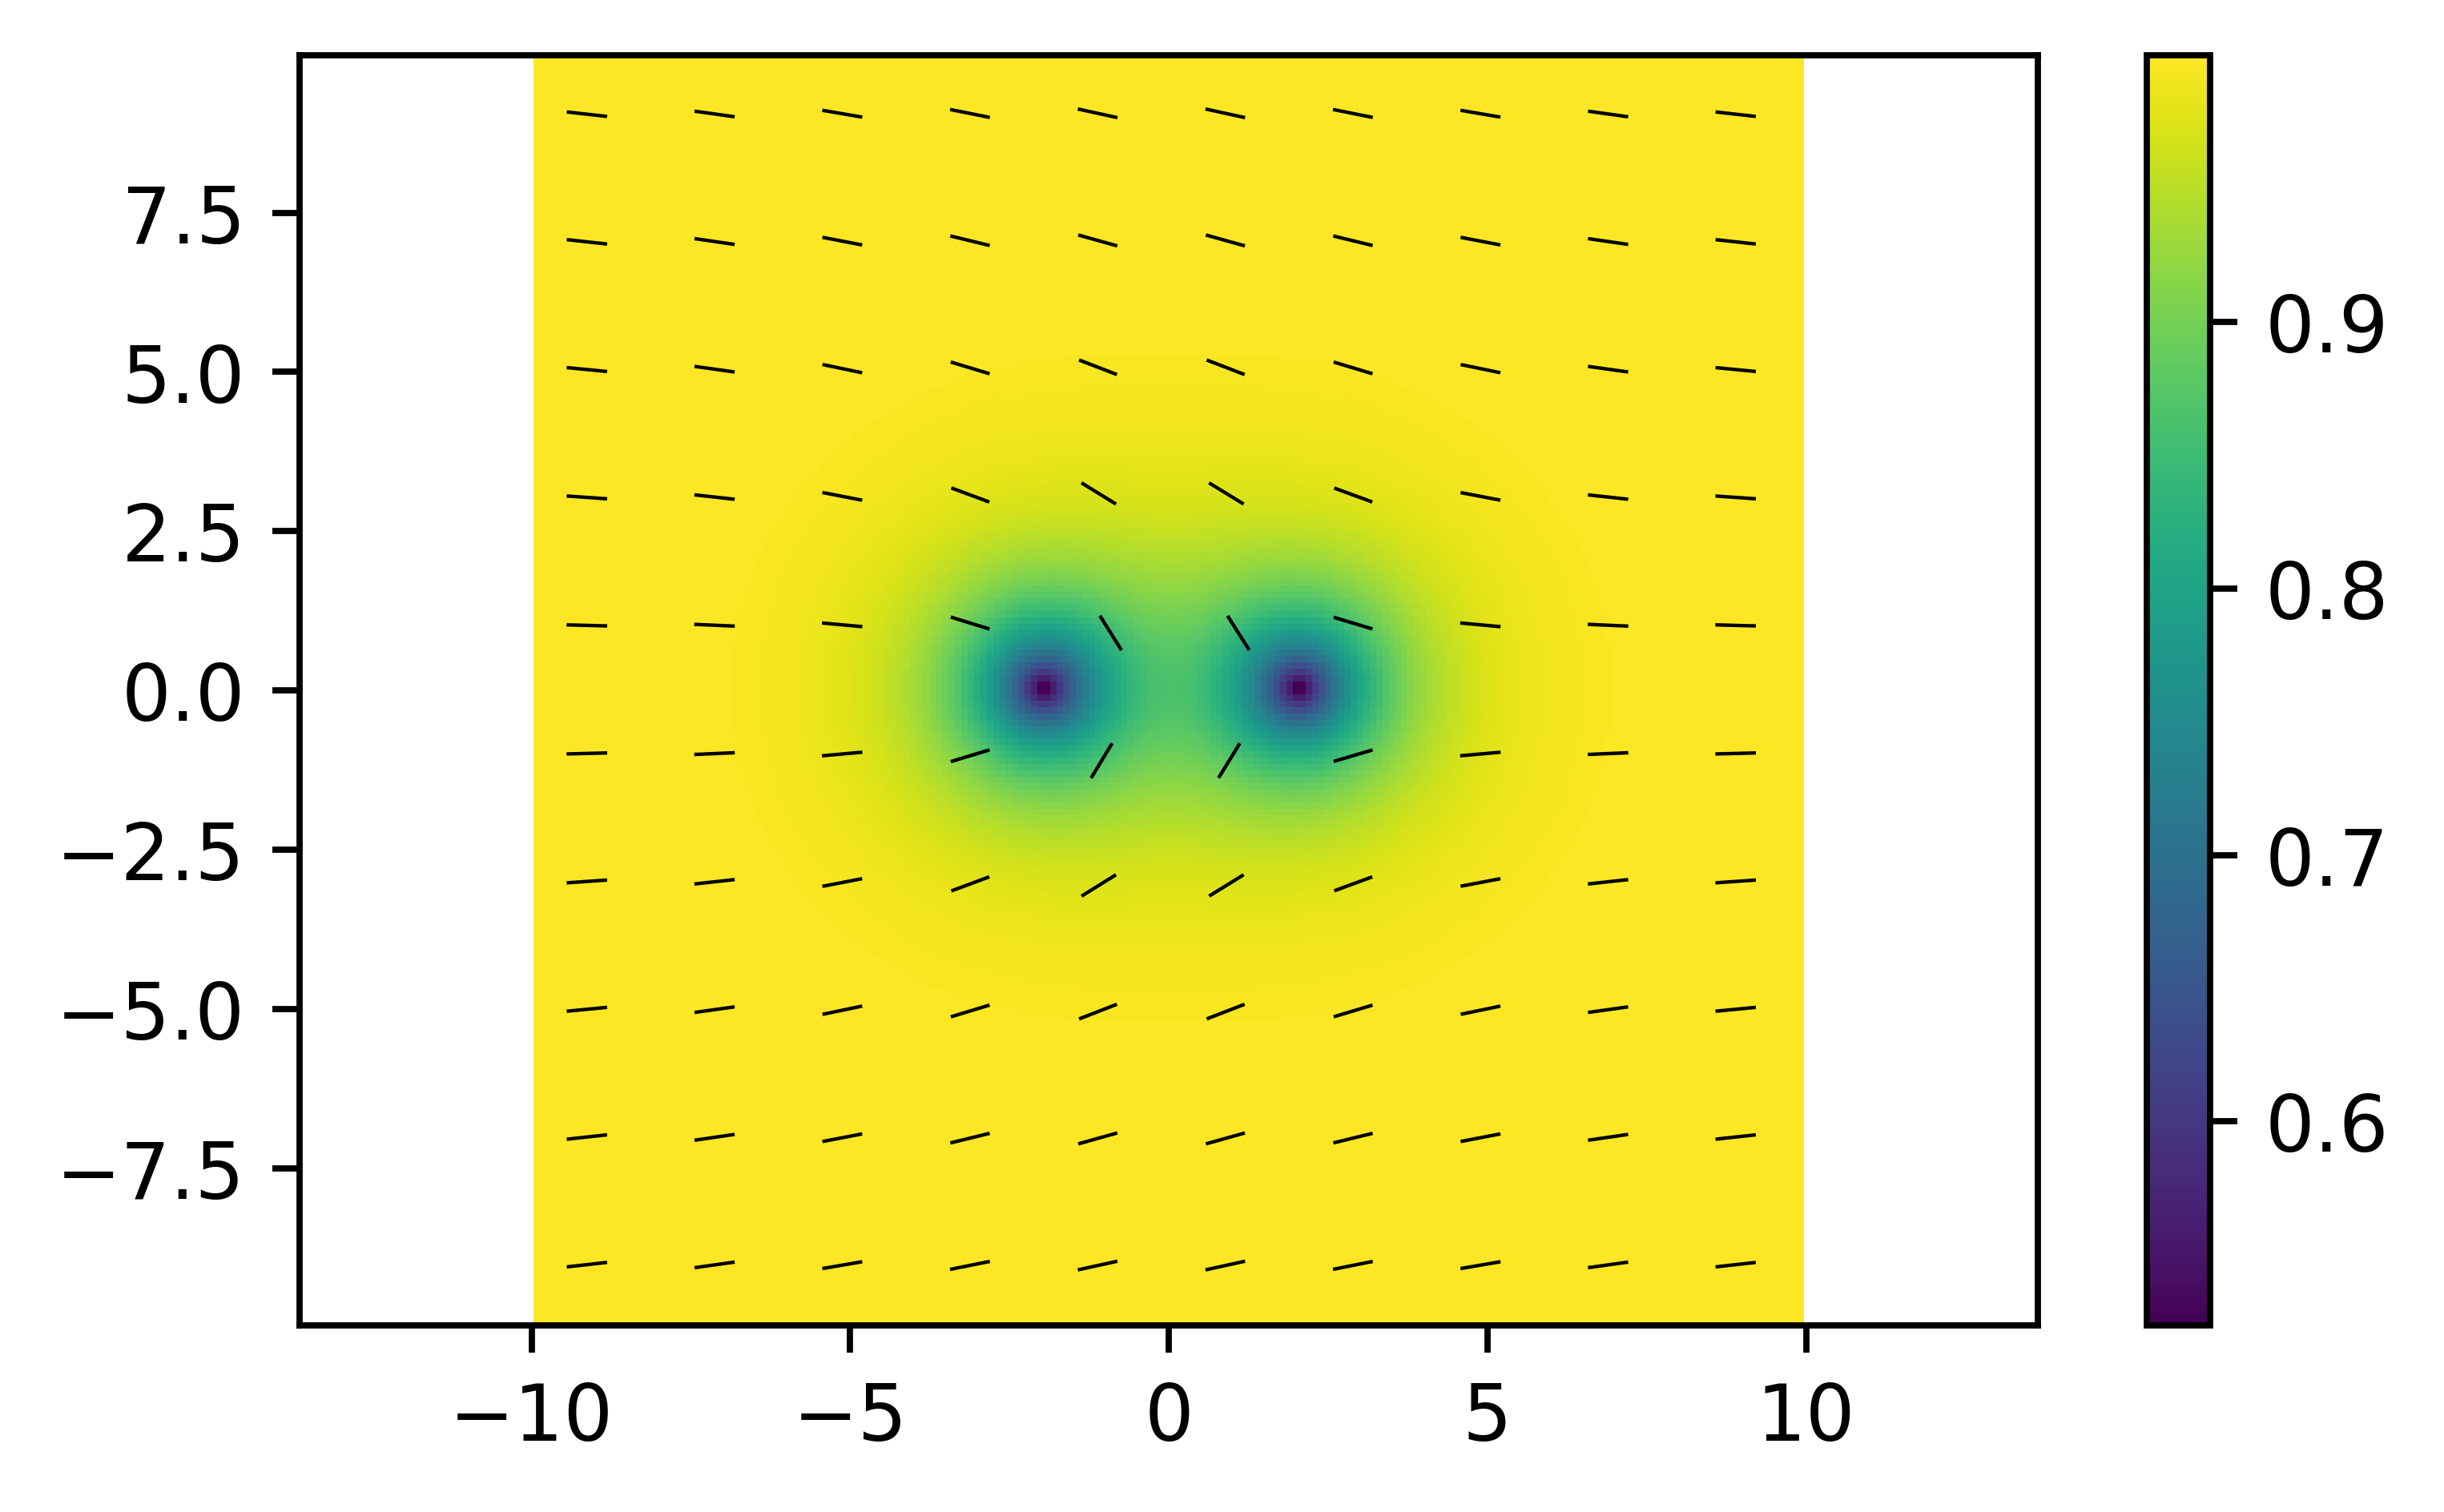

In [273]:
sparse_shape = (10, 10)
S_sparse_shape = (200, 200)
S_cutoff = 0.3

lambda_pm = lch.calcQEigenvals(eta, mu, nu)
U, V = lch.calcQEigenvecs(eta, mu, nu, lambda_pm, S_cutoff)

sparse_idx = lch.sparseIdx(Q[0, 0].shape, sparse_shape)
S_sparse_idx = lch.sparseIdx(Q[0, 0].shape, S_sparse_shape)

fig, ax = plt.subplots(figsize=(5, 3))
c = ax.pcolor(X[S_sparse_idx], Y[S_sparse_idx], S[S_sparse_idx])
q = ax.quiver(X[sparse_idx], Y[sparse_idx], U[sparse_idx], V[sparse_idx],
              headwidth=0, pivot='middle', headaxislength=5, scale=30, width=0.002)
ax.quiverkey(q, X=0.3, Y=1.1, U=10,
             label='Quiver key, length = 10', labelpos='E')
ax.axis('equal')
fig.colorbar(c, ax=ax)

In [282]:
peaks = np.zeros((2, n), dtype='int')
for i in range(n):
    peaks[:, i], _ = find_peaks(-lambda_pm[:, i])

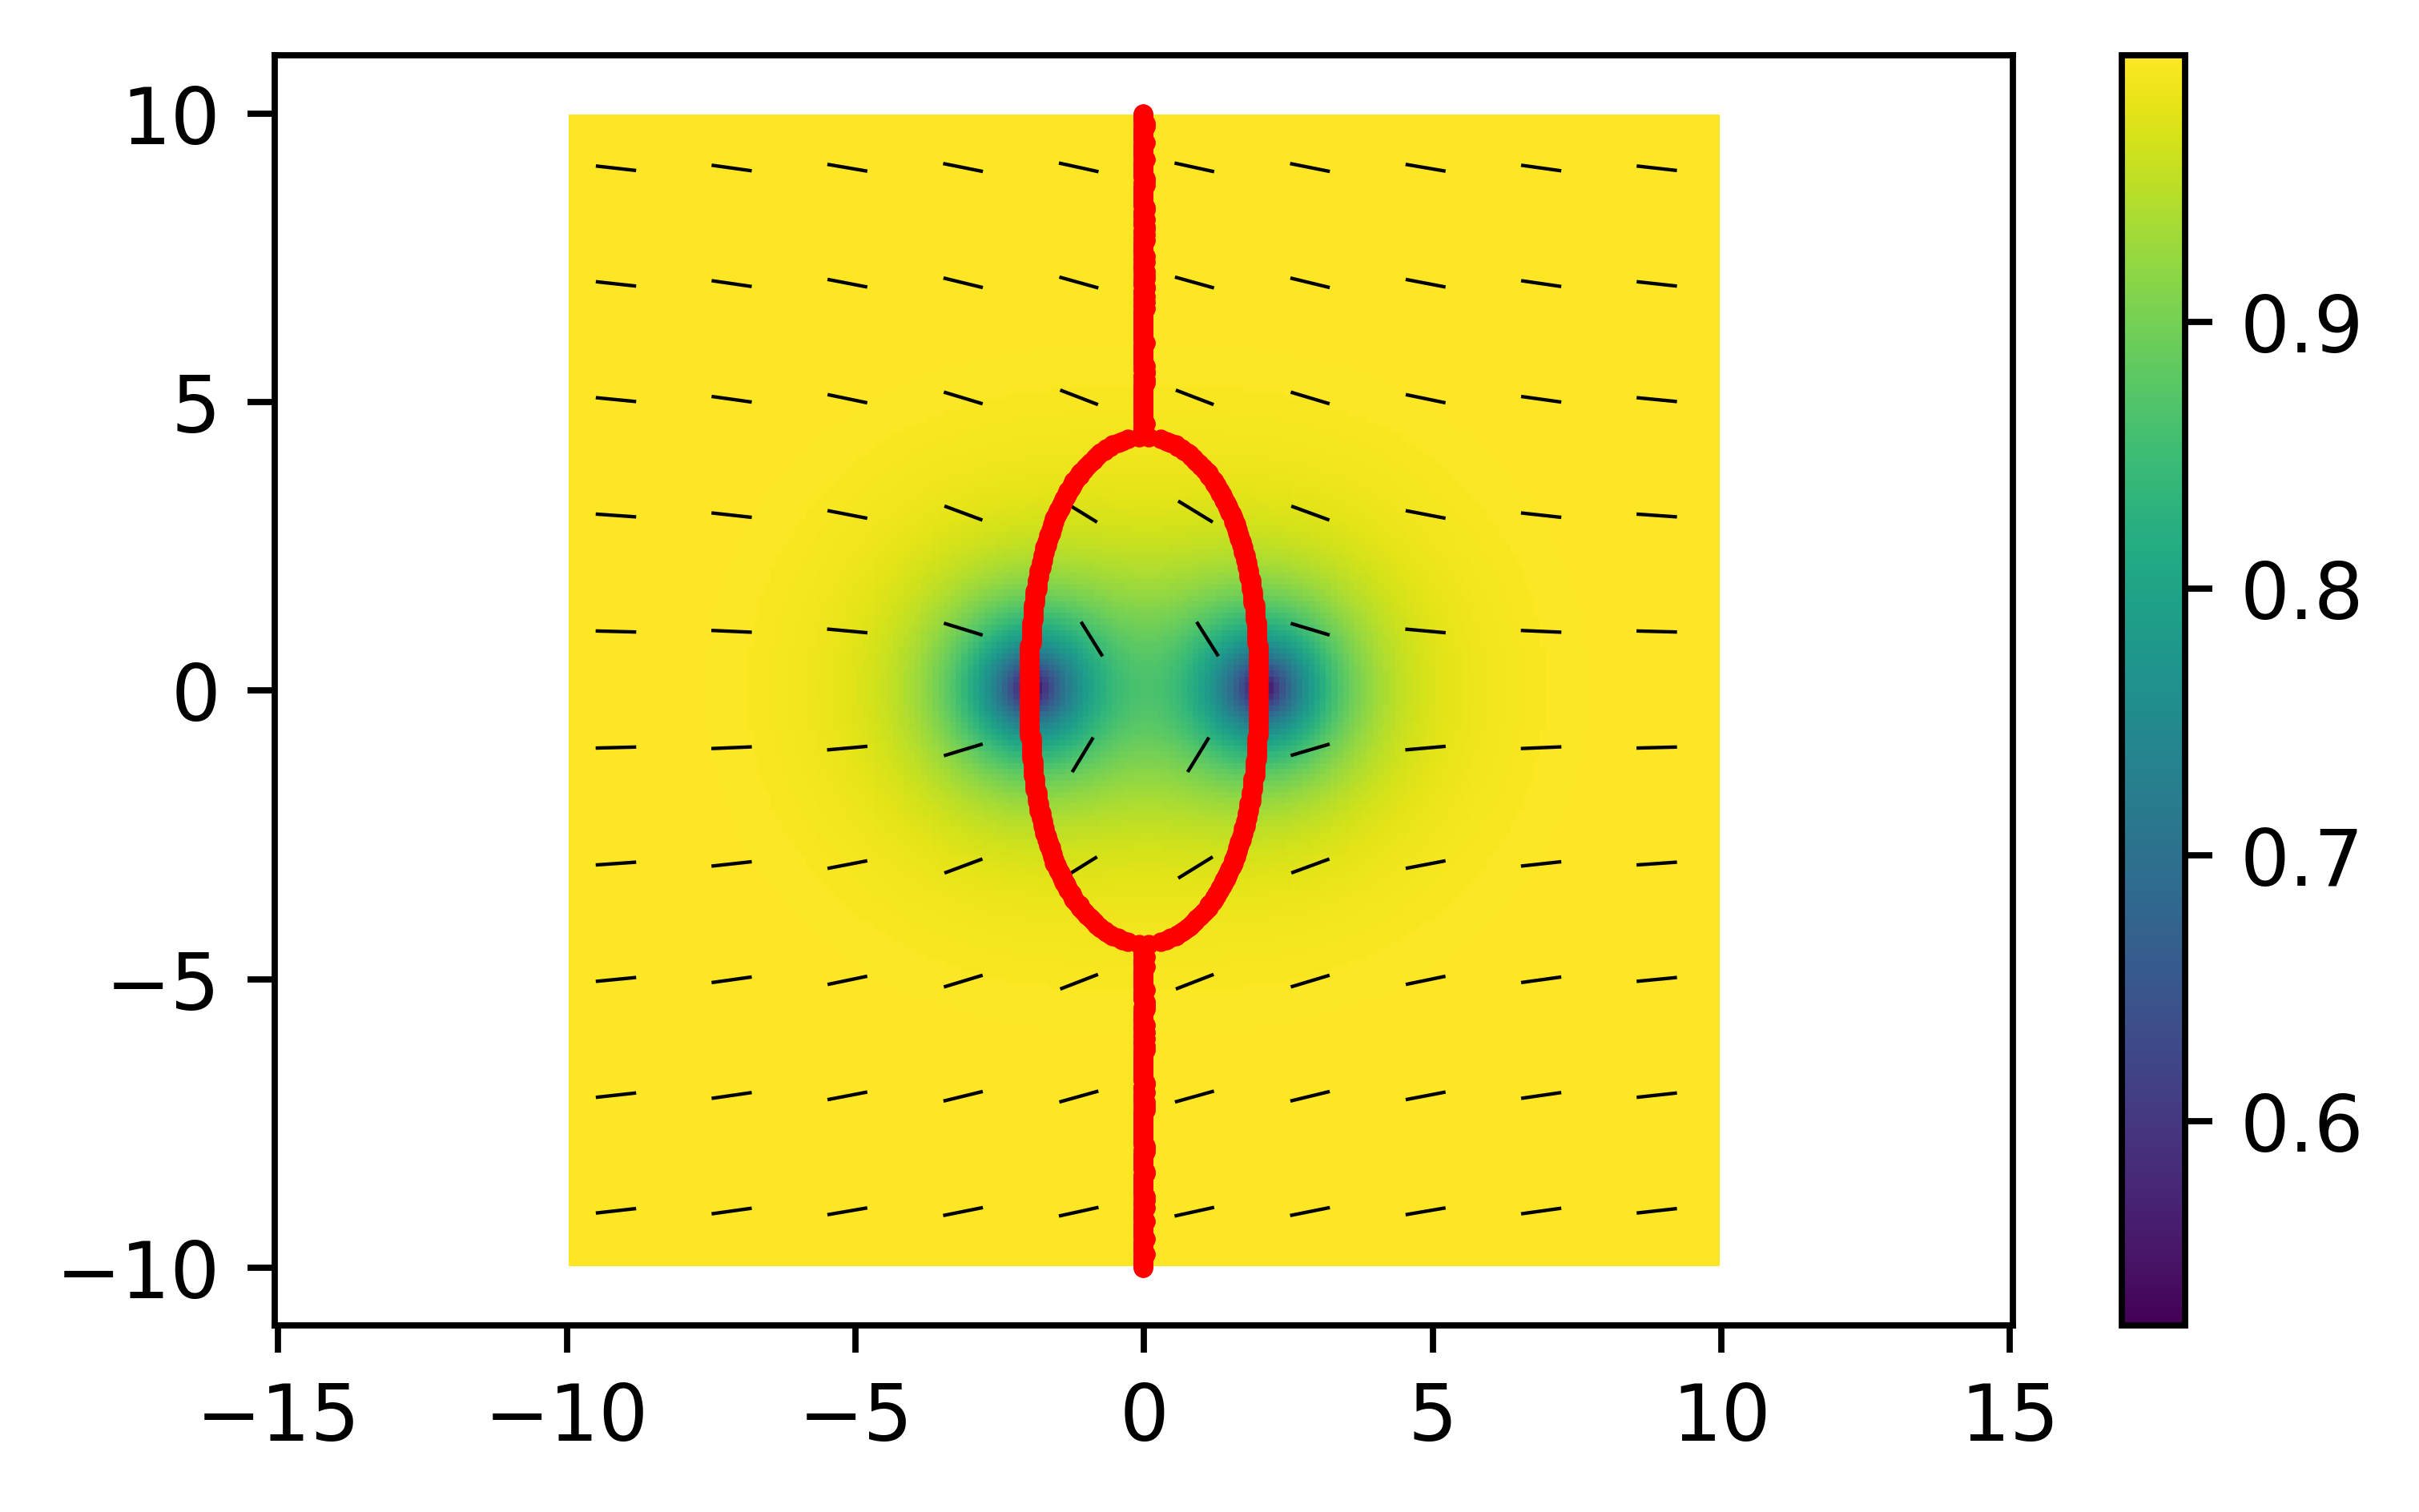

In [310]:
fig, ax = plt.subplots(figsize=(5, 3))
c = ax.pcolor(X[S_sparse_idx], Y[S_sparse_idx], S[S_sparse_idx])
q = ax.quiver(X[sparse_idx], Y[sparse_idx], U[sparse_idx], V[sparse_idx],
              headwidth=0, pivot='middle', headaxislength=5, scale=30, width=0.002)
ax.quiverkey(q, X=0.3, Y=1.1, U=10,
             label='Quiver key, length = 10', labelpos='E')

for i in range(n):
    ax.plot(X[peaks[0, i], 0], Y[0, i], marker='o', c='r', markersize=1.5)
    ax.plot(X[peaks[1, i], 0], Y[0, i], marker='o', c='r', markersize=1.5)
    
ax.axis('equal')
fig.colorbar(c, ax=ax)

In [298]:
peak1_vals = np.diagonal(lambda_pm[peaks[0, :], :])
peak2_vals = np.diagonal(lambda_pm[peaks[1, :], :])

In [305]:
peak1_arg = np.argmin(peak1_vals)
peak2_arg = np.argmin(peak2_vals)

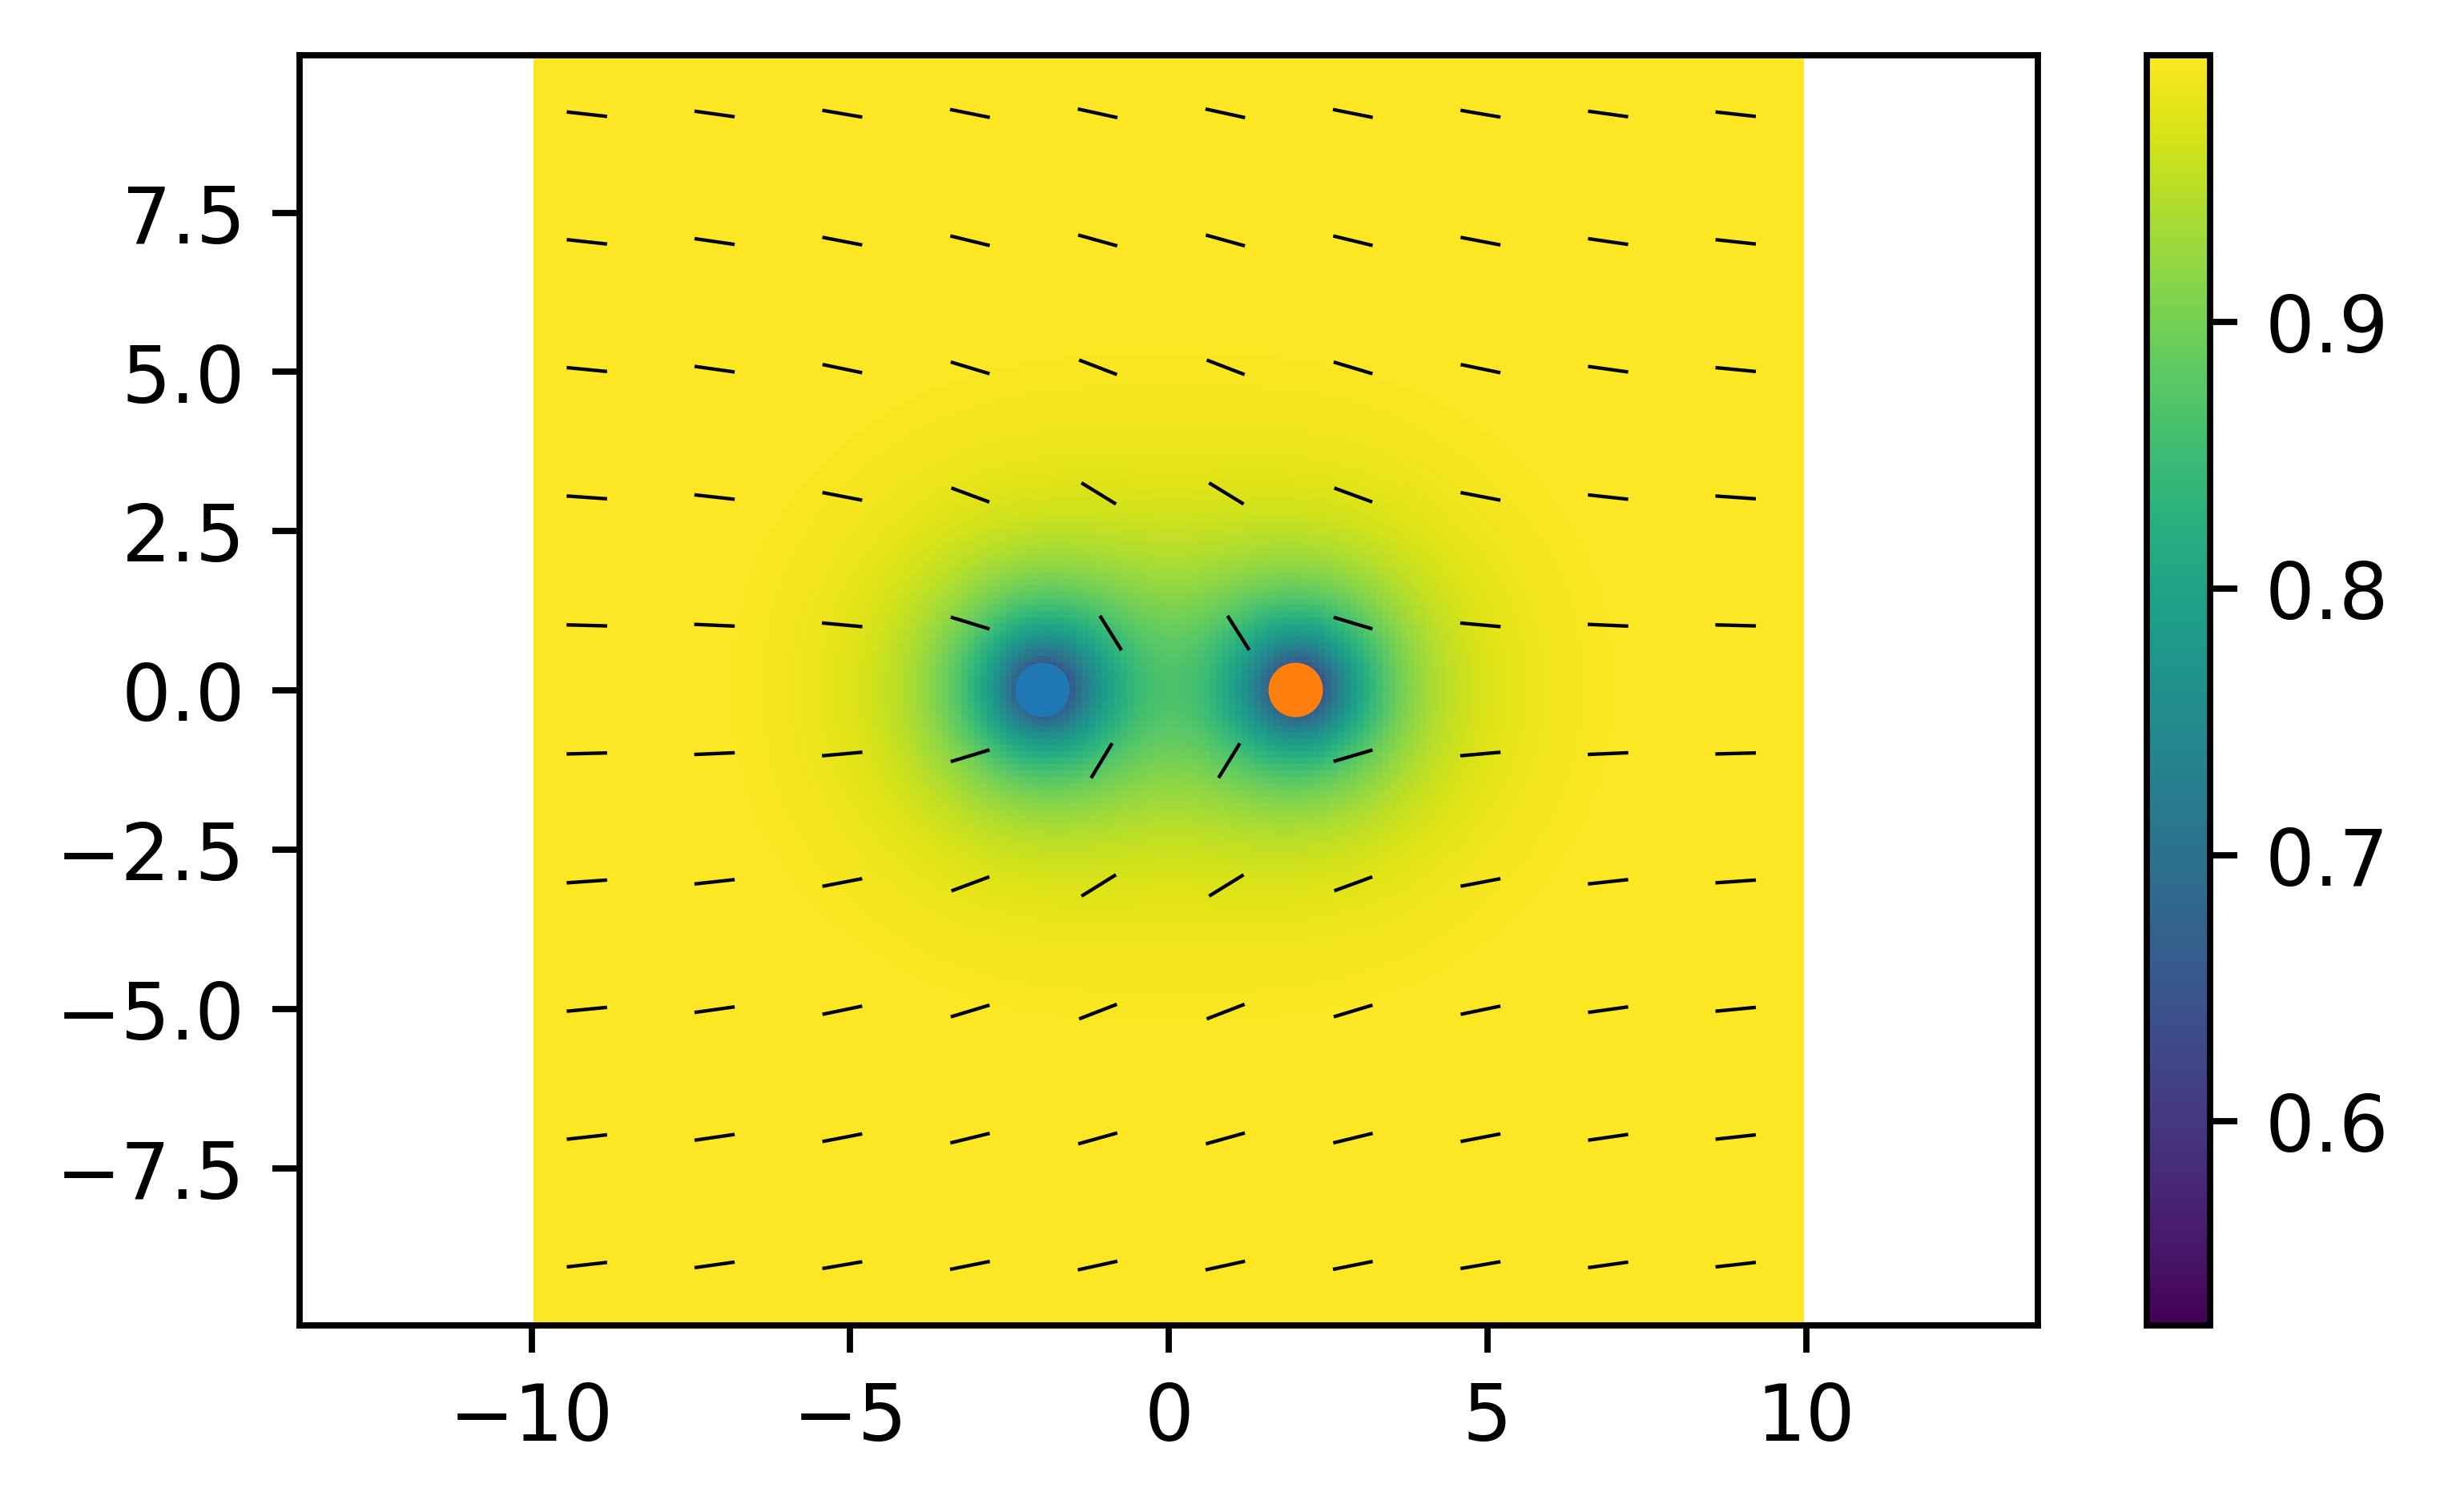

In [308]:
fig, ax = plt.subplots(figsize=(5, 3))
c = ax.pcolor(X[S_sparse_idx], Y[S_sparse_idx], S[S_sparse_idx])
q = ax.quiver(X[sparse_idx], Y[sparse_idx], U[sparse_idx], V[sparse_idx],
              headwidth=0, pivot='middle', headaxislength=5, scale=30, width=0.002)
ax.quiverkey(q, X=0.3, Y=1.1, U=10,
             label='Quiver key, length = 10', labelpos='E')

plt.plot(X[peaks[0, peak1_arg], 0], Y[0, peak1_arg], marker='o')
plt.plot(X[peaks[1, peak2_arg], 0], Y[0, peak2_arg], marker='o')
    
ax.axis('equal')
fig.colorbar(c, ax=ax)

### Now I just need to apply this scheme to a particular run -- hopefully it doesn't take too much longer
### Actually I need to think about how to implement it better and then turn it into an actual piece of code.

In [316]:
l = 10
n = 300

x = np.linspace(-l, l, num=n)
y = np.linspace(-l, l, num=n)
X, Y = np.meshgrid(x, y, indexing='ij')

S_val = 0.5
ctr = [[-2, 0], [2, 0]]
r = [1, 1]
m = [-1/2, 1/2]

S, phi = lch.makeMultiDisclination(X, Y, S_val, ctr, r, m)
Q = lch.uniaxialQ(S, phi)
eta, mu, nu = lch.auxVars(Q)

In [335]:
n_defects = 2
num_steps = 10000
peak_pos = np.zeros((2, num_steps))
t = np.zeros(num_steps)
x_locs = np.zeros((n_defects, num_steps))
y_locs = np.zeros((n_defects, num_steps))

eta_old = eta
mu_old = mu
nu_old = nu

# Create loading bar
progress = widgets.IntProgress(min=0, max=num_steps)
display(progress)

for i in range(num_steps):
    
    eta_new = fd.forwardEuler(eta_old, dt, lch.etaEOM, mu_old, nu_old, dx, dy)
    mu_new = fd.forwardEuler(mu_old, dt, lch.muEOM, eta_old, nu_old, dx, dy)
    nu_new = fd.forwardEuler(nu_old, dt, lch.nuEOM, eta_old, mu_old, dx, dy)
    
    eta_old = eta_new
    mu_old = mu_new
    nu_old = nu_new
    
    lambda_max = lch.calcQEigenvals(eta_old, mu_old, nu_old)
    x_locs[:, i], y_locs[:, i] = lch.findDefectCenters(lambda_max, X, Y)
    
    t[i] = i*dt
    
    # Update loading bar
    progress.value = i


IntProgress(value=0, max=10000)

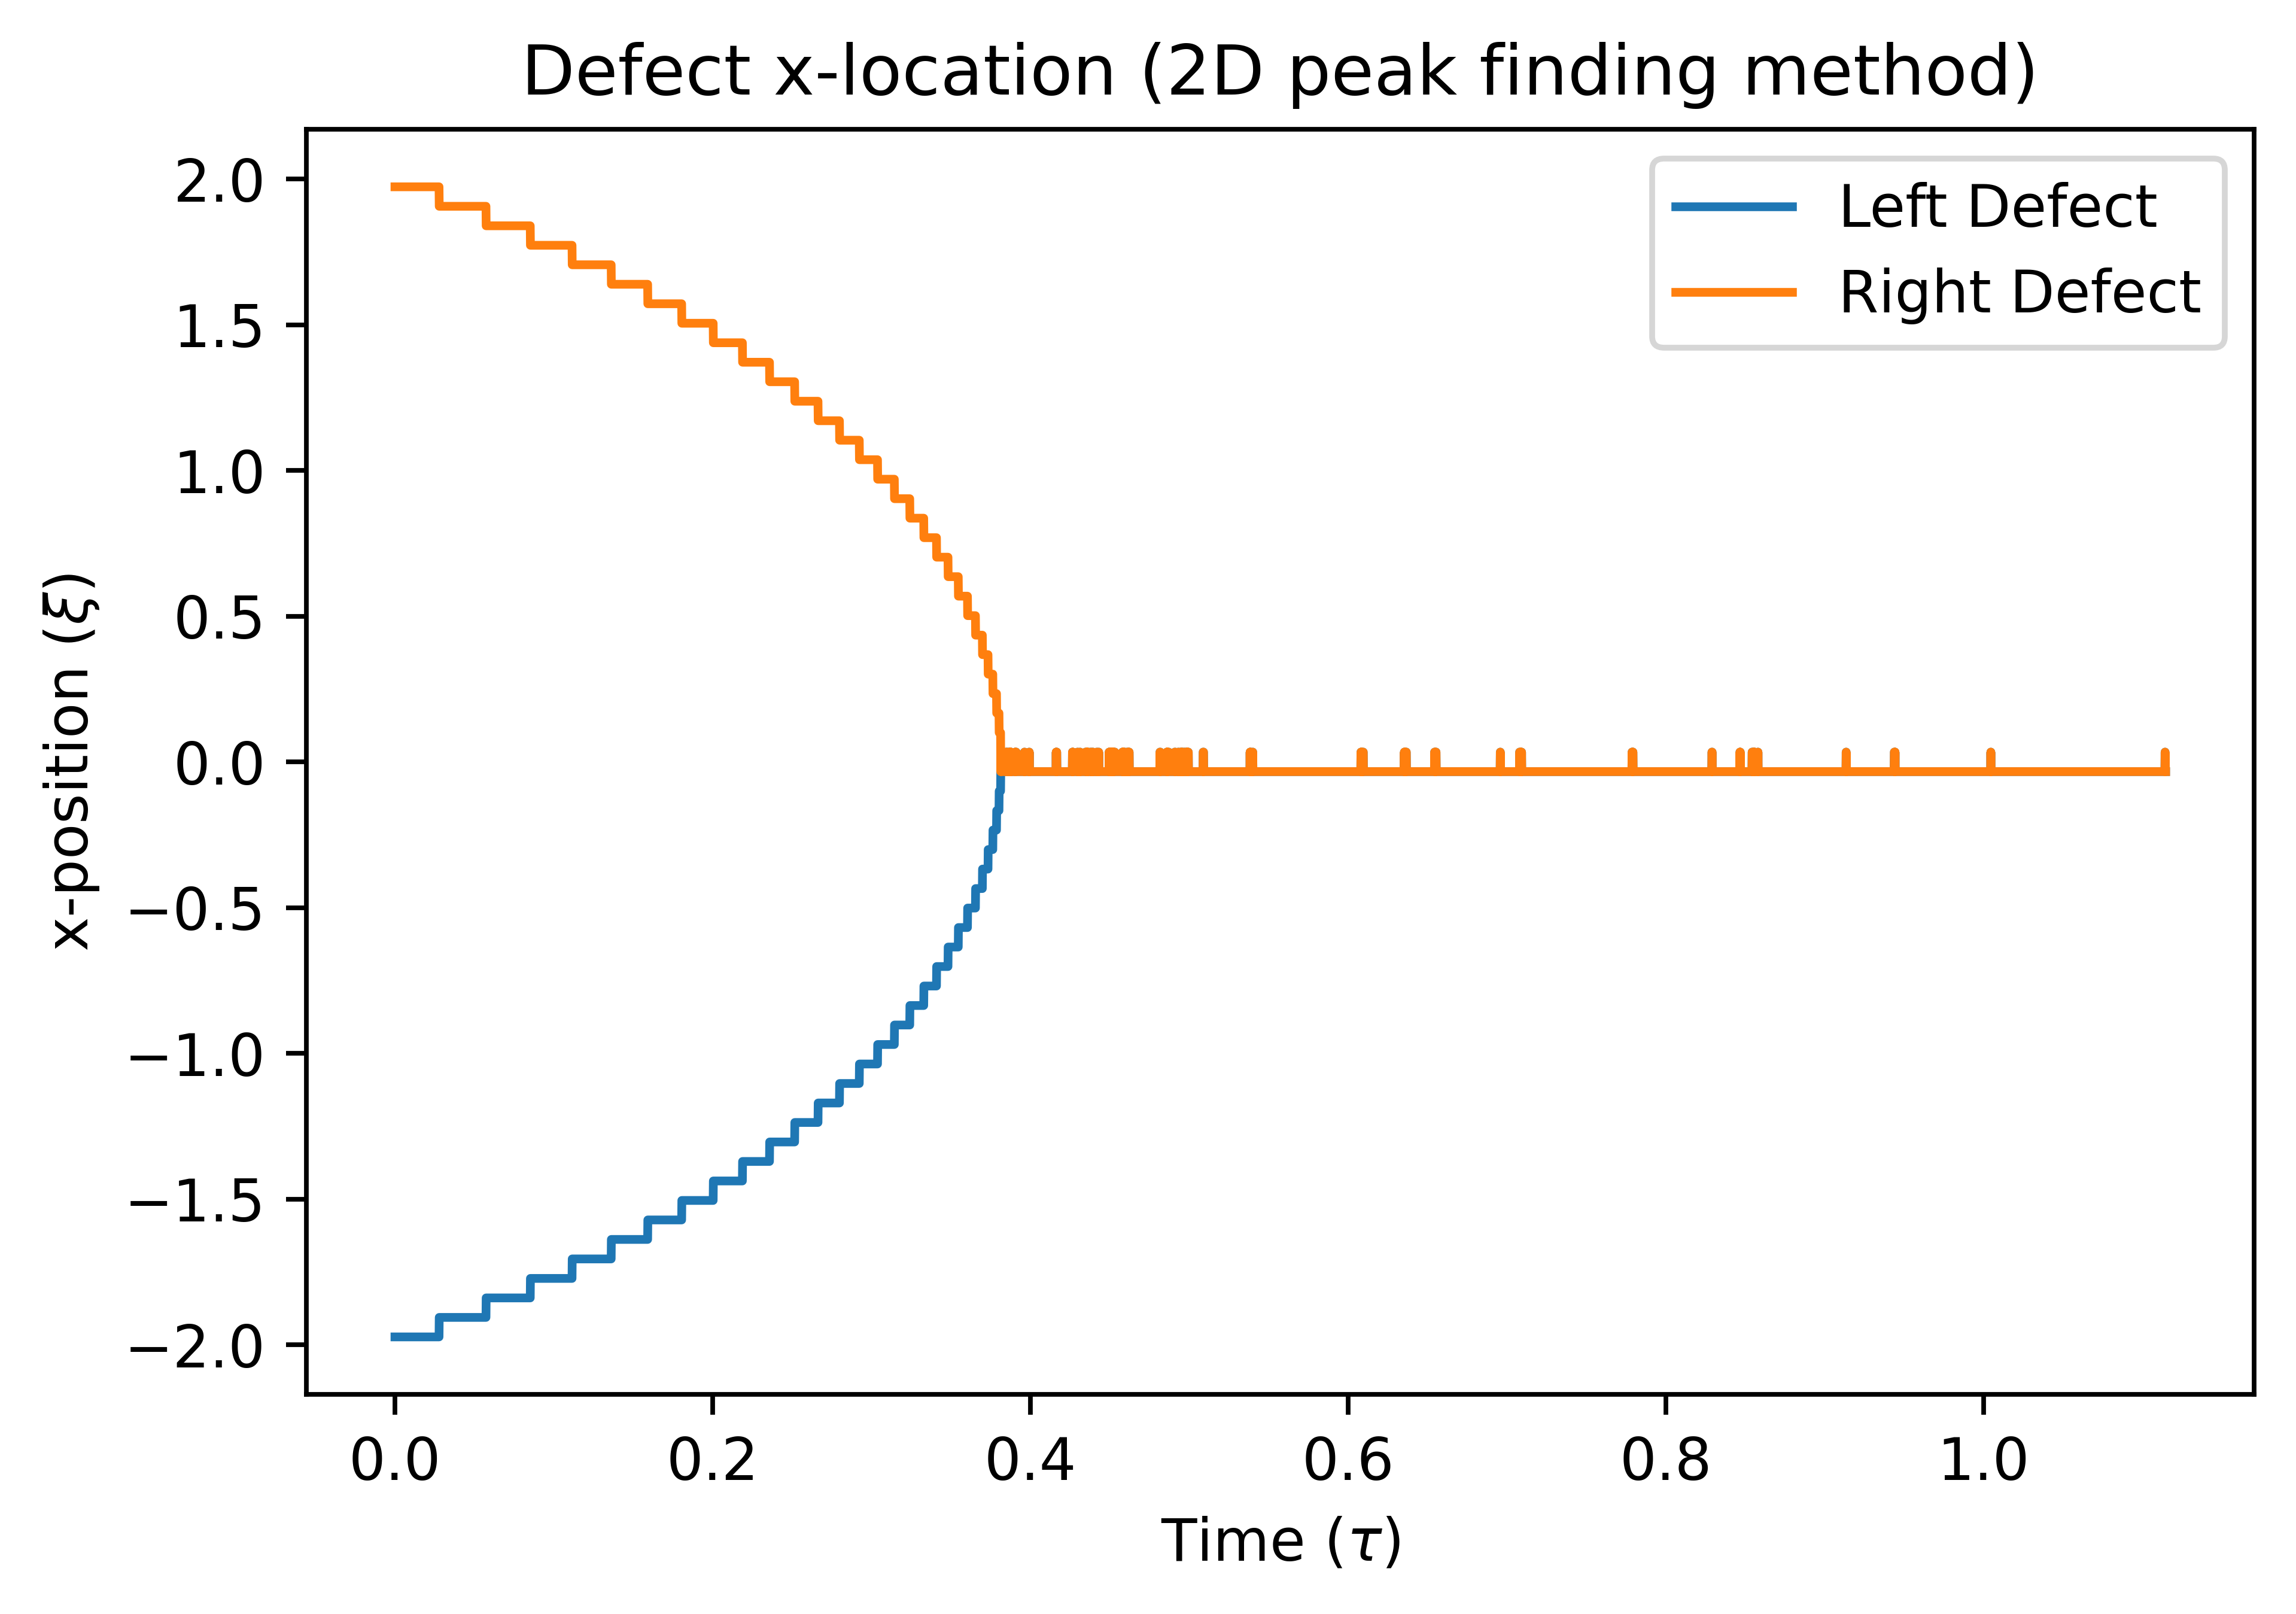

In [342]:
plt.plot(t, x_locs[0, :], label="Left Defect")
plt.plot(t, x_locs[1, :], label="Right Defect")
plt.title("Defect x-location (2D peak finding method)")
plt.xlabel(r"Time ($\tau$)")
plt.ylabel(r"x-position ($\xi$)")
plt.legend()

plt.savefig("DefectLocation2DMethod.png")